# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/EhWeqeQsh-9Mr1fneZc9_0sBOBzEdXngvxFJtAlIa-eAgA?e=8ukWwa). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ).

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

Machine Learning (ML) is an appropriate and effective solution for this problem.
The dataset contains millions of past flight records with structured attributes such as airline, origin, destination, departure time, distance, and historical delay information. These variables exhibit complex, nonlinear relationships that traditional rule-based systems or statistical summaries cannot easily capture.

By training ML models on this historical data, we can learn patterns that predict future flight delays, such as:

* Congested routes or airports that tend to cause delays,

* Time-of-day and seasonal trends,

* Airline-specific operational performance, and

* Weather or distance effects on on-time performance.

Deploying an ML model helps airlines, airports, and passengers anticipate potential delays in advance, improving operational planning, resource allocation, and customer satisfaction.
Therefore, using ML is justified because:

* The problem involves predictive analytics on large-scale structured data,

* There is sufficient historical labeled data available,

* And the output (delay prediction) provides tangible business value through better decision-making and efficiency.

### 2. Formulate the business problem, success metrics, and desired ML output.

# Write your answer here and turn the cell type into markdown
## Business problem

Airlines and airports want to reduce the frequency and impact of flight delays. Using the BTS on-time performance data (2014–2018), we predict whether an arriving flight will be delayed (arrival delay > 15 minutes). Outputs (predicted probability / class) can be used to:

* Proactively reassign gates/crews,

* Alert connecting passengers,

* Schedule buffer times for high-risk routes,

* Plan targeted interventions for carriers or airports with systemic delays.

## Success metric / business goal

* Primary objective: maximize recall (sensitivity) on the delayed class while keeping false-positives acceptably low (so operational actions are not triggered too often).

* Secondary: AUC-ROC and precision at a reasonable recall (e.g., keep precision > 0.4 while recall > 0.6 — tune based on business-cost model).

### 3. Identify the type of ML problem you’re dealing with.

# Write your answer here and turn the cell type into markdown
This is a Supervised Learning – Classification problem.

* Input: Flight attributes (date, airline, origin, destination, scheduled/actual times, etc.)

* Output/Target: Whether the flight is delayed or not delayed (usually encoded as 1 = delayed, 0 = on time).

The model learns from labeled historical data where the delay outcome is known and aims to predict the delay status for new flights.

If you model delay time as a continuous number (e.g., minutes late), it could alternatively be treated as a Regression problem — but since the objective here is to classify flights as delayed or on-time, the appropriate framing is binary classification.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [1]:
import os
from pathlib import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [2]:
# download the files

# <note: make them all relative, absolute path is not accepted>
base_path = './'
extracted_root_path = './data_extracted/'  # Root extracted folder
nested_zip_path = './data_extracted/data_compressed/'  # Folder with the 60 zip files
csv_base_path = './extracted_csv/'  # Where we'll extract the final CSVs

# Create directories if they don't exist
import os
os.makedirs(extracted_root_path, exist_ok=True)
os.makedirs(nested_zip_path, exist_ok=True) 
os.makedirs(csv_base_path, exist_ok=True)

print("Directory structure created")

Directory structure created


In [3]:
# Cell: Check the nested zip files in data_extracted/data_compressed/
if os.path.exists(nested_zip_path):
    nested_zip_files = [f for f in os.listdir(nested_zip_path) if f.endswith('.zip')]
    print(f"Number of zip files in nested data_compressed folder: {len(nested_zip_files)}")
    print("First 10 nested zip files:")
    for f in nested_zip_files[:10]:
        print(f"  - {f}")
else:
    print(f"Path {nested_zip_path} does not exist. Please check your file structure.")

Number of zip files in nested data_compressed folder: 60
First 10 nested zip files:
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip


In [5]:
# How many zip files do we have? write a code to answer it.
# Cell: Check how many zip files we have in the data_compressed folder
zip_files = [f for f in os.listdir(nested_zip_path) if f.endswith('.zip')]
print(f"Number of zip files in data_compressed folder: {len(zip_files)}")
print("First 10 zip files:")
for f in zip_files[:10]:
    print(f"  - {f}")

Number of zip files in data_compressed folder: 60
First 10 zip files:
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_7.zip


#### Extract CSV files from ZIP files

In [13]:
# Cell: Extract CSV files from ZIP files - modified for nested structure
# Cell: Extract CSV files from the nested zip structure
def extract_nested_zips(zip_folder_path, extract_path):
    """
    Extract CSV files from zip files in the nested structure
    zip_folder_path: path to folder containing the 60 zip files
    extract_path: where to extract the final CSV files
    """
    zip_files = [f for f in os.listdir(zip_folder_path) if f.endswith('.zip')]
    total_files = len(zip_files)
    
    print(f"Found {total_files} zip files to extract")
    
    for i, zip_file in enumerate(zip_files):
        if i % 10 == 0:  # Print progress every 10 files
            print(f"Progress: {i+1}/{total_files}")
            
        try:
            zip_full_path = os.path.join(zip_folder_path, zip_file)
            
            with ZipFile(zip_full_path, 'r') as z:
                # List all files in the zip
                file_list = z.namelist()
                csv_files_in_zip = [f for f in file_list if f.endswith('.csv')]
                
                if csv_files_in_zip:
                    print(f"Extracting {zip_file} -> {csv_files_in_zip[0]}")
                    # Extract the CSV file
                    z.extract(csv_files_in_zip[0], path=extract_path)
                    
                    # Rename if needed to avoid overwrites
                    original_path = os.path.join(extract_path, csv_files_in_zip[0])
                    new_name = f"{zip_file.replace('.zip', '')}_{csv_files_in_zip[0]}"
                    new_path = os.path.join(extract_path, new_name)
                    
                    # If file with same name exists, rename it
                    if os.path.exists(original_path):
                        if os.path.exists(new_path):
                            os.remove(new_path)  # Remove if already exists
                        os.rename(original_path, new_path)
                        
                else:
                    print(f"No CSV found in {zip_file}")
                    
        except Exception as e:
            print(f"Error extracting {zip_file}: {str(e)}")
    
    print("Extraction completed!")

# Run the extraction
if os.path.exists(nested_zip_path):
    extract_nested_zips(nested_zip_path, csv_base_path)
else:
    print("Nested zip path not found. Please check the file structure.")

Found 60 zip files to extract
Progress: 1/60
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip -> On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip -> On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_10.csv
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip -> On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_11.csv
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip -> On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_12.csv
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip -> On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_2.csv
Extracting On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip -> On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_3.csv
Extracting On

In [14]:
# How many csv files have we extracted? write a code to answer it.
# Cell: Check how many CSV files we extracted and their names
csv_files = [f for f in os.listdir(csv_base_path) if f.endswith('.csv')]
print(f"Number of CSV files extracted: {len(csv_files)}")
print("First 10 CSV files:")
for f in csv_files[:10]:
    print(f"  - {f}")

# Check file sizes
for f in csv_files[:5]:
    file_path = os.path.join(csv_base_path, f)
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  - {f}: {size_mb:.2f} MB")

Number of CSV files extracted: 60
First 10 CSV files:
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_10.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_11.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_12.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_2.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_3.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4_On_Time_Reporting_

Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [15]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

In [17]:
# Cell: Find all CSV files recursively in the extraction folder
def find_all_csv_files(root_path):
    """
    Recursively find all CSV files in a directory structure
    """
    csv_files = []
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.csv'):
                full_path = os.path.join(root, file)
                csv_files.append(full_path)
    return csv_files

# Find all CSV files
all_csv_files = find_all_csv_files(csv_base_path)
print(f"Total CSV files found: {len(all_csv_files)}")
print("First 10 CSV files:")
for f in all_csv_files[:10]:
    print(f"  - {os.path.basename(f)}")

Total CSV files found: 60
First 10 CSV files:
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_10.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_11.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_12.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_2.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_3.csv
  - On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4_On_Time_Reporting_Carrier_

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [20]:
#df_temp = pd.read_csv(<CODE> # **ENTER YOUR CODE HERE**
# Cell: Load a sample CSV to check the structure
if all_csv_files:
    sample_csv = all_csv_files[0]
    print(f"Loading sample: {os.path.basename(sample_csv)}")
    
    try:
        df_temp = pd.read_csv(sample_csv, low_memory=False, encoding='ISO-8859-1')
        print("Successfully loaded with ISO-8859-1 encoding")
    except UnicodeDecodeError:
        try:
            df_temp = pd.read_csv(sample_csv, low_memory=False, encoding='latin-1')
            print("Successfully loaded with latin-1 encoding")
        except Exception as e:
            print(f"Failed to load: {e}")
            df_temp = pd.read_csv(sample_csv, low_memory=False, encoding='utf-8')
            print("Successfully loaded with utf-8 encoding")
    
    print(f"Sample shape: {df_temp.shape}")
    print("\nFirst 10 rows:")
    display(df_temp.head(10))
    
    print("\nColumns:")
    for i, col in enumerate(df_temp.columns):
        print(f"{i+1:2d}. {col}")

Loading sample: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10_On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_10.csv
Successfully loaded with ISO-8859-1 encoding
Sample shape: (491011, 110)

First 10 rows:


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2014,4,10,1,3,2014-10-01,AA,19805,AA,N785AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,4,10,2,4,2014-10-02,AA,19805,AA,N783AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,4,10,3,5,2014-10-03,AA,19805,AA,N786AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,4,10,4,6,2014-10-04,AA,19805,AA,N784AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,4,10,5,7,2014-10-05,AA,19805,AA,N792AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,4,10,6,1,2014-10-06,AA,19805,AA,N788AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,4,10,7,2,2014-10-07,AA,19805,AA,N797AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,4,10,8,3,2014-10-08,AA,19805,AA,N789AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014,4,10,9,4,2014-10-09,AA,19805,AA,N794AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,4,10,10,5,2014-10-10,AA,19805,AA,N799AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columns:
 1. Year
 2. Quarter
 3. Month
 4. DayofMonth
 5. DayOfWeek
 6. FlightDate
 7. Reporting_Airline
 8. DOT_ID_Reporting_Airline
 9. IATA_CODE_Reporting_Airline
10. Tail_Number
11. Flight_Number_Reporting_Airline
12. OriginAirportID
13. OriginAirportSeqID
14. OriginCityMarketID
15. Origin
16. OriginCityName
17. OriginState
18. OriginStateFips
19. OriginStateName
20. OriginWac
21. DestAirportID
22. DestAirportSeqID
23. DestCityMarketID
24. Dest
25. DestCityName
26. DestState
27. DestStateFips
28. DestStateName
29. DestWac
30. CRSDepTime
31. DepTime
32. DepDelay
33. DepDelayMinutes
34. DepDel15
35. DepartureDelayGroups
36. DepTimeBlk
37. TaxiOut
38. WheelsOff
39. WheelsOn
40. TaxiIn
41. CRSArrTime
42. ArrTime
43. ArrDelay
44. ArrDelayMinutes
45. ArrDel15
46. ArrivalDelayGroups
47. ArrTimeBlk
48. Cancelled
49. CancellationCode
50. Diverted
51. CRSElapsedTime
52. ActualElapsedTime
53. AirTime
54. Flights
55. Distance
56. DistanceGroup
57. CarrierDelay
58. WeatherDelay
59. NASDelay
6

**Question**: Print the row and column length in the dataset, and print the column names.

In [19]:
df_shape = df_temp.shape # **ENTER YOUR CODE HERE**
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (491011, 110)


**Question**: Print the first 10 rows of the dataset.  

In [ ]:
# Enter your code here

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [ ]:
print(f'The column names are :')
print('#########')
for col in <CODE>:# **ENTER YOUR CODE HERE**
    print(col)


IndentationError: unexpected indent (1824939678.py, line 2)

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [23]:
# Enter your code here
# Cell: Print all columns containing 'Del'
if 'df_temp' in locals():
    # Method 1: Using list comprehension with 'in' keyword
    del_columns = [col for col in df_temp.columns if 'Del' in col]
    
    print("Columns containing 'Del':")
    print("-" * 40)
    
    if del_columns:
        for i, col in enumerate(del_columns, 1):
            print(f"{i:2d}. {col}")
        print(f"\nTotal columns with 'Del': {len(del_columns)}")
    else:
        print("No columns found containing 'Del'")
    


Columns containing 'Del':
----------------------------------------
 1. DepDelay
 2. DepDelayMinutes
 3. DepDel15
 4. DepartureDelayGroups
 5. ArrDelay
 6. ArrDelayMinutes
 7. ArrDel15
 8. ArrivalDelayGroups
 9. CarrierDelay
10. WeatherDelay
11. NASDelay
12. SecurityDelay
13. LateAircraftDelay
14. DivArrDelay

Total columns with 'Del': 14


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [24]:
# to answer above questions, complete the following code
# Cell: Answer dataset information questions
if 'df_temp' in locals():
    print("DATASET INFORMATION")
    print("=" * 50)
    
    # 1. How many rows and columns does the dataset have?
    num_rows, num_cols = df_temp.shape
    print(f"1. Rows and columns: {num_rows:,} rows, {num_cols} columns")
    
    # 2. How many years are included in the dataset?
    if 'Year' in df_temp.columns:
        years = sorted(df_temp['Year'].unique())
        print(f"2. Years included: {len(years)} years → {years}")
    else:
        print("2. Years included: 'Year' column not found")
    
    # 3. What is the date range for the dataset?
    if 'FlightDate' in df_temp.columns:
        min_date = df_temp['FlightDate'].min()
        max_date = df_temp['FlightDate'].max()
        print(f"3. Date range: {min_date} to {max_date}")
        
        # Additional: Number of unique dates
        unique_dates = df_temp['FlightDate'].nunique()
        print(f"   Unique dates: {unique_dates}")
    else:
        print("3. Date range: 'FlightDate' column not found")
    
    # 4. Which airlines are included in the dataset?
    if 'Reporting_Airline' in df_temp.columns:
        airlines = sorted(df_temp['Reporting_Airline'].unique())
        print(f"4. Airlines included: {len(airlines)} airlines → {airlines}")
        
        # Additional: Count of flights per airline
        airline_counts = df_temp['Reporting_Airline'].value_counts()
        print("   Flights per airline:")
        for airline, count in airline_counts.items():
            print(f"     - {airline}: {count:,} flights")
    else:
        print("4. Airlines included: 'Reporting_Airline' column not found")
    
    # 5. Which origin and destination airports are covered?
    print("5. Airports coverage:")
    if 'Origin' in df_temp.columns:
        origin_airports = sorted(df_temp['Origin'].unique())
        print(f"   - Origin airports: {len(origin_airports)} airports")
        print(f"     First 10: {origin_airports[:10]}")
        
        # Top 10 busiest origin airports
        top_origins = df_temp['Origin'].value_counts().head(10)
        print("     Top 10 busiest origin airports:")
        for airport, count in top_origins.items():
            print(f"       {airport}: {count:,} flights")
    
    if 'Dest' in df_temp.columns:
        dest_airports = sorted(df_temp['Dest'].unique())
        print(f"   - Destination airports: {len(dest_airports)} airports")
        print(f"     First 10: {dest_airports[:10]}")
        
        # Top 10 busiest destination airports
        top_dests = df_temp['Dest'].value_counts().head(10)
        print("     Top 10 busiest destination airports:")
        for airport, count in top_dests.items():
            print(f"       {airport}: {count:,} flights")
    
    print("=" * 50)
    
else:
    print("Sample dataframe not available. Please load the data first.")

DATASET INFORMATION
1. Rows and columns: 491,011 rows, 110 columns
2. Years included: 1 years → [2014]
3. Date range: 2014-10-01 to 2014-10-31
   Unique dates: 31
4. Airlines included: 14 airlines → ['AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'OO', 'UA', 'US', 'VX', 'WN']
   Flights per airline:
     - WN: 99,257 flights
     - DL: 70,676 flights
     - EV: 56,533 flights
     - OO: 51,019 flights
     - AA: 45,113 flights
     - UA: 43,335 flights
     - US: 35,634 flights
     - MQ: 32,010 flights
     - B6: 20,113 flights
     - AS: 13,398 flights
     - F9: 8,211 flights
     - HA: 6,329 flights
     - VX: 4,722 flights
     - FL: 4,661 flights
5. Airports coverage:
   - Origin airports: 309 airports
     First 10: ['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK']
     Top 10 busiest origin airports:
       ATL: 31,618 flights
       ORD: 26,257 flights
       DFW: 23,519 flights
       DEN: 19,416 flights
       LAX: 18,199 flights
       IAH: 14,74

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [25]:
# Cell: Count of all origin and destination airports
if 'df_temp' in locals():
    print("COUNT OF ORIGIN AND DESTINATION AIRPORTS")
    print("=" * 60)
    
    # Count unique airports in Origin and Dest columns
    if 'Origin' in df_temp.columns and 'Dest' in df_temp.columns:
        # Get value counts for origin and destination airports
        origin_counts = df_temp['Origin'].value_counts()
        dest_counts = df_temp['Dest'].value_counts()
        
        # Create a combined dataframe for comparison
        airport_counts = pd.DataFrame({
            'Origin_Count': origin_counts,
            'Destination_Count': dest_counts
        }).fillna(0)
        
        # Convert to integers
        airport_counts['Origin_Count'] = airport_counts['Origin_Count'].astype(int)
        airport_counts['Destination_Count'] = airport_counts['Destination_Count'].astype(int)
        
        # Add total flights column
        airport_counts['Total_Flights'] = airport_counts['Origin_Count'] + airport_counts['Destination_Count']
        
        print(f"Total unique airports: {len(airport_counts)}")
        print(f"Total origin flights: {airport_counts['Origin_Count'].sum():,}")
        print(f"Total destination flights: {airport_counts['Destination_Count'].sum():,}")
        print(f"Total flights (origin + destination): {airport_counts['Total_Flights'].sum():,}")
        
        print("\nFirst 20 airports with their counts:")
        print("-" * 50)
        print(f"{'Airport':<8} {'Origin':>10} {'Destination':>12} {'Total':>10}")
        print("-" * 50)
        for airport in airport_counts.index[:20]:
            orig = airport_counts.loc[airport, 'Origin_Count']
            dest = airport_counts.loc[airport, 'Destination_Count']
            total = airport_counts.loc[airport, 'Total_Flights']
            print(f"{airport:<8} {orig:>10,} {dest:>12,} {total:>10,}")
            
    else:
        print("Required columns 'Origin' and/or 'Dest' not found in dataset")
else:
    print("Sample dataframe not available. Please load the data first.")

COUNT OF ORIGIN AND DESTINATION AIRPORTS
Total unique airports: 310
Total origin flights: 491,011
Total destination flights: 491,011
Total flights (origin + destination): 982,022

First 20 airports with their counts:
--------------------------------------------------
Airport      Origin  Destination      Total
--------------------------------------------------
ABE             172          171        343
ABI             240          240        480
ABQ           2,071        2,073      4,144
ABR              72           72        144
ABY              86           85        171
ACK              24           24         48
ACT             151          151        302
ACV             286          287        573
ACY              62           62        124
ADK               9            9         18
ADQ              31           31         62
AEX             294          294        588
AGS             205          205        410
ALB             676          677      1,353
ALO              58  

**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [26]:
# Cell: Top 15 origin and destination airports based on number of flights
if 'df_temp' in locals():
    print("TOP 15 ORIGIN AND DESTINATION AIRPORTS")
    print("=" * 70)
    
    if 'Origin' in df_temp.columns and 'Dest' in df_temp.columns:
        # Get top 15 origin airports
        top_origins = df_temp['Origin'].value_counts().head(15)
        top_destinations = df_temp['Dest'].value_counts().head(15)
        
        # Create a comparison dataframe
        top_airports_comparison = pd.DataFrame({
            'Origin_Rank': range(1, 16),
            'Origin_Airport': top_origins.index,
            'Origin_Flights': top_origins.values,
            'Destination_Rank': range(1, 16),
            'Destination_Airport': top_destinations.index,
            'Destination_Flights': top_destinations.values
        })
        
        print("Top 15 Busiest Airports:")
        print("-" * 70)
        print(f"{'Rank':<4} {'Origin Airport':<15} {'Flights':>12} | {'Rank':<4} {'Dest Airport':<15} {'Flights':>12}")
        print("-" * 70)
        
        for i in range(15):
            orig_rank = i + 1
            dest_rank = i + 1
            
            orig_airport = top_airports_comparison.loc[i, 'Origin_Airport']
            orig_flights = top_airports_comparison.loc[i, 'Origin_Flights']
            
            dest_airport = top_airports_comparison.loc[i, 'Destination_Airport']
            dest_flights = top_airports_comparison.loc[i, 'Destination_Flights']
            
            print(f"{orig_rank:<4} {orig_airport:<15} {orig_flights:>12,} | {dest_rank:<4} {dest_airport:<15} {dest_flights:>12,}")
        
        # Additional analysis: Airports that appear in both top 15 lists
        common_airports = set(top_origins.index) & set(top_destinations.index)
        print(f"\nAirports in both top 15 lists: {len(common_airports)}")
        print(f"Common airports: {sorted(common_airports)}")
        
        # Airports only in origin top 15
        only_origin = set(top_origins.index) - set(top_destinations.index)
        if only_origin:
            print(f"Airports only in origin top 15: {sorted(only_origin)}")
        
        # Airports only in destination top 15  
        only_dest = set(top_destinations.index) - set(top_origins.index)
        if only_dest:
            print(f"Airports only in destination top 15: {sorted(only_dest)}")
            
    else:
        print("Required columns 'Origin' and/or 'Dest' not found in dataset")
else:
    print("Sample dataframe not available. Please load the data first.")

TOP 15 ORIGIN AND DESTINATION AIRPORTS
Top 15 Busiest Airports:
----------------------------------------------------------------------
Rank Origin Airport       Flights | Rank Dest Airport         Flights
----------------------------------------------------------------------
1    ATL                   31,618 | 1    ATL                   31,613
2    ORD                   26,257 | 2    ORD                   26,310
3    DFW                   23,519 | 3    DFW                   23,523
4    DEN                   19,416 | 4    DEN                   19,411
5    LAX                   18,199 | 5    LAX                   18,196
6    IAH                   14,742 | 6    IAH                   14,757
7    SFO                   14,499 | 7    SFO                   14,489
8    PHX                   13,347 | 8    PHX                   13,346
9    LAS                   11,779 | 9    LAS                   11,782
10   CLT                    9,755 | 10   CLT                    9,746
11   BOS                

**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

In [27]:
# Enter your answer here
# Cell: Flight delay prediction feasibility analysis
if 'df_temp' in locals():
    print("FLIGHT DELAY PREDICTION FEASIBILITY ANALYSIS")
    print("=" * 65)
    
    # Check if delay-related columns exist
    delay_columns = [col for col in df_temp.columns if 'Del' in col or 'Delay' in col]
    
    if delay_columns:
        print("Delay-related columns found in dataset:")
        for col in delay_columns:
            print(f"  - {col}")
        
        print("\n" + "-" * 65)
        
        # Check specifically for ArrDel15 which is our target variable
        if 'ArrDel15' in df_temp.columns:
            delay_distribution = df_temp['ArrDel15'].value_counts(normalize=True) * 100
            
            print("ARRIVAL DELAY DISTRIBUTION (ArrDel15):")
            print(f"  - Flights NOT delayed (>15 min): {delay_distribution.get(0, 0):.2f}%")
            print(f"  - Flights delayed (>15 min): {delay_distribution.get(1, 0):.2f}%")
            
            # Check for missing values in target
            missing_target = df_temp['ArrDel15'].isna().sum()
            if missing_target > 0:
                print(f"  - Missing values in target: {missing_target} ({missing_target/len(df_temp)*100:.2f}%)")
        
        # Analyze other potential delay indicators
        delay_analysis_cols = ['ArrDelayMinutes', 'DepDelayMinutes', 'CarrierDelay', 
                              'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
        
        available_delay_cols = [col for col in delay_analysis_cols if col in df_temp.columns]
        
        if available_delay_cols:
            print(f"\nAdditional delay metrics available ({len(available_delay_cols)}):")
            for col in available_delay_cols:
                non_zero = (df_temp[col] > 0).sum()
                percentage = (non_zero / len(df_temp)) * 100
                print(f"  - {col}: {non_zero:,} flights with delay ({percentage:.2f}%)")
        
        # Check for features that could predict delays
        predictive_features = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                              'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'CRSDepTime']
        
        available_features = [col for col in predictive_features if col in df_temp.columns]
        
        print(f"\nPREDICTIVE FEATURES ANALYSIS:")
        print(f"Available features for prediction: {len(available_features)}/{len(predictive_features)}")
        print("Available features:")
        for feature in available_features:
            unique_vals = df_temp[feature].nunique()
            data_type = df_temp[feature].dtype
            print(f"  - {feature}: {unique_vals} unique values ({data_type})")
        
        print("\nCONCLUSION:")
        if 'ArrDel15' in df_temp.columns and len(available_features) >= 5:
            print("✅ YES - Flight delay prediction is feasible with this dataset.")
            print("   Reasons:")
            print("   - Clear target variable (ArrDel15) exists")
            print("   - Multiple predictive features available")
            print("   - Sufficient data volume for machine learning")
            print("   - Various delay causes documented (weather, carrier, etc.)")
        else:
            print("❌ Limited feasibility with current data")
            if 'ArrDel15' not in df_temp.columns:
                print("   - Target delay variable not found")
            if len(available_features) < 5:
                print("   - Insufficient predictive features")
                
    else:
        print("No delay-related columns found in the dataset.")
        print("Delay prediction may not be feasible with the available columns.")
        
    print("=" * 65)
    
else:
    print("Sample dataframe not available. Please load the data first.")

FLIGHT DELAY PREDICTION FEASIBILITY ANALYSIS
Delay-related columns found in dataset:
  - DepDelay
  - DepDelayMinutes
  - DepDel15
  - DepartureDelayGroups
  - ArrDelay
  - ArrDelayMinutes
  - ArrDel15
  - ArrivalDelayGroups
  - CarrierDelay
  - WeatherDelay
  - NASDelay
  - SecurityDelay
  - LateAircraftDelay
  - DivArrDelay

-----------------------------------------------------------------
ARRIVAL DELAY DISTRIBUTION (ArrDel15):
  - Flights NOT delayed (>15 min): 80.97%
  - Flights delayed (>15 min): 19.03%
  - Missing values in target: 5998 (1.22%)

Additional delay metrics available (7):
  - ArrDelayMinutes: 190,567 flights with delay (38.81%)
  - DepDelayMinutes: 176,757 flights with delay (36.00%)
  - CarrierDelay: 45,905 flights with delay (9.35%)
  - WeatherDelay: 3,346 flights with delay (0.68%)
  - NASDelay: 55,826 flights with delay (11.37%)
  - SecurityDelay: 178 flights with delay (0.04%)
  - LateAircraftDelay: 49,906 flights with delay (10.16%)

PREDICTIVE FEATURES ANALYSI

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [31]:
# Cell: Combine all CSV files with filtering for specific airports and airlines
print("COMBINING ALL CSV FILES WITH FILTERING")
print("=" * 70)

def combine_filtered_csv(csv_file_paths, filter_cols, subset_cols, subset_vals, output_file):
    """
    Combine and filter CSV files for specific airports and airlines
    csv_file_paths: list of full paths to CSV files
    filter_cols: list of columns to keep
    subset_cols: list of columns to filter on
    subset_vals: list of values to filter for each column
    output_file: path for output combined CSV
    """
    # Create an empty dataframe
    df_combined = pd.DataFrame()
    total_files = len(csv_file_paths)
    
    print(f"Starting to combine {total_files} CSV files with filtering...")
    print(f"Filtering for:")
    print(f"  - Origin airports: {subset_vals[0]}")
    print(f"  - Destination airports: {subset_vals[1]}")
    print(f"  - Airlines: {subset_vals[2]}")
    print(f"  - Keeping {len(filter_cols)} columns")
    
    processed_files = 0
    total_rows = 0
    
    for i, csv_path in enumerate(csv_file_paths):
        if i % 5 == 0:  # Print progress every 5 files
            print(f"Progress: {i+1}/{total_files} files, {total_rows:,} rows collected...")
        
        try:
            # Read the CSV file with appropriate encoding
            try:
                df = pd.read_csv(csv_path, low_memory=False)
            except UnicodeDecodeError:
                df = pd.read_csv(csv_path, low_memory=False, encoding='latin-1')
            except Exception as e:
                print(f"  Skipping {os.path.basename(csv_path)} due to read error: {e}")
                continue
            
            # Filter columns - only keep columns that exist in the dataframe
            existing_cols = [col for col in filter_cols if col in df.columns]
            if not existing_cols:
                continue
                
            df_filter = df[existing_cols]
            
            # Subset rows based on criteria - only apply filters for columns that exist
            mask = pd.Series([True] * len(df_filter))
            
            for col, vals in zip(subset_cols, subset_vals):
                if col in df_filter.columns:
                    mask = mask & df_filter[col].isin(vals)
            
            # Apply the filter
            df_subset = df_filter[mask]
            
            # Only concatenate if we have data after filtering
            if len(df_subset) > 0:
                # CORRECTED: Remove duplicate ignore_index parameter
                df_combined = pd.concat([df_combined, df_subset], ignore_index=True)
                total_rows = len(df_combined)
                processed_files += 1
            
        except Exception as e:
            print(f"Error processing {os.path.basename(csv_path)}: {str(e)}")
            continue
    
    # Save to file
    if len(df_combined) > 0:
        df_combined.to_csv(output_file, index=False)
        print(f"\n✅ Combination completed successfully!")
        print(f"📁 Processed {processed_files}/{total_files} files")
        print(f"📊 Final dataset: {len(df_combined):,} rows, {len(df_combined.columns)} columns")
        print(f"💾 Saved to: {output_file}")
    else:
        print(f"\n❌ No data found after applying filters")
    
    return df_combined

# Define the columns we want to keep for prediction
filter_cols = [
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
    'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
    'CRSDepTime', 'DepDelayMinutes', 'DepartureDelayGroups', 'Cancelled', 
    'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 
    'ArrDel15', 'AirTime'
]

# Define the columns to filter on
subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# Define the values to filter for (top airports and airlines)
subset_vals = [
    ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],  # Origin airports
    ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'],  # Destination airports
    ['UA', 'OO', 'WN', 'AA', 'DL']  # Airlines
]

# Output file name
combined_csv_filename = f"{base_path}combined_filtered_files.csv"

# Check which columns are actually available in our sample
if 'df_temp' in locals():
    available_cols = [col for col in filter_cols if col in df_temp.columns]
    missing_cols = [col for col in filter_cols if col not in df_temp.columns]
    
    print(f"Columns available in dataset: {len(available_cols)}/{len(filter_cols)}")
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
    
    # Update filter_cols to only include available columns
    filter_cols = available_cols
    print(f"Will use {len(filter_cols)} available columns for filtering")

# Combine all files with filtering
import time
start_time = time.time()

combined_data = combine_filtered_csv(all_csv_files, filter_cols, subset_cols, subset_vals, combined_csv_filename)

end_time = time.time()
processing_minutes = (end_time - start_time) / 60
print(f"⏱️ Total processing time: {processing_minutes:.2f} minutes")

print("\n" + "=" * 70)

COMBINING ALL CSV FILES WITH FILTERING
Columns available in dataset: 22/22
Will use 22 available columns for filtering
Starting to combine 60 CSV files with filtering...
Filtering for:
  - Origin airports: ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO']
  - Destination airports: ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO']
  - Airlines: ['UA', 'OO', 'WN', 'AA', 'DL']
  - Keeping 22 columns
Progress: 1/60 files, 0 rows collected...
Progress: 6/60 files, 114,913 rows collected...
Progress: 11/60 files, 232,864 rows collected...
Progress: 16/60 files, 371,209 rows collected...
Progress: 21/60 files, 487,663 rows collected...
Progress: 26/60 files, 635,476 rows collected...
Progress: 31/60 files, 779,914 rows collected...
Progress: 36/60 files, 937,123 rows collected...
Progress: 41/60 files, 1,081,226 rows collected...
Progress: 46/60 files, 1,225,583 rows collected...
Progress: 51/60 files, 1,372,188 rows collected...
Progress: 56/60 files, 1,509,971 ro

In [32]:
# Cell: Analysis of features known before flight for SFO-LAX route
print("FEATURES KNOWN BEFORE FLIGHT - SFO to LAX ANALYSIS")
print("=" * 65)

# Features that would be known BEFORE the flight
features_known_before = [
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
    'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
    'CRSDepTime', 'Distance', 'DistanceGroup'
]

# Features that would be known only AFTER or DURING the flight
features_known_after = [
    'DepDelayMinutes', 'DepartureDelayGroups', 'Cancelled', 'Diverted',
    'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'AirTime'
]

print("FEATURES KNOWN WHEN BOOKING/PLANNING TRIP:")
print("-" * 45)
for i, feature in enumerate(features_known_before, 1):
    print(f"{i:2d}. {feature}")

print(f"\nTotal features known before flight: {len(features_known_before)}")

print("\nFEATURES THAT BECOME KNOWN DURING/AFTER FLIGHT:")
print("-" * 45)
for i, feature in enumerate(features_known_after, 1):
    print(f"{i:2d}. {feature}")

print(f"\nTotal features known during/after flight: {len(features_known_after)}")

print("\n" + "=" * 65)
print("BUSINESS IMPLICATION FOR SFO-LAX TRIP:")
print("For predicting delays when booking a flight from SFO to LAX:")
print(f"✅ We can use {len(features_known_before)} features available at booking time")
print("❌ We CANNOT use real-time delay information (those would be our target)")
print("\nThis means we can build a predictive model using historical patterns")
print("based on date, airline, route, and scheduled departure time.")

# Check specifically for SFO-LAX route in our sample data
if 'df_temp' in locals() and 'Origin' in df_temp.columns and 'Dest' in df_temp.columns:
    sfo_lax_flights = df_temp[(df_temp['Origin'] == 'SFO') & (df_temp['Dest'] == 'LAX')]
    
    if len(sfo_lax_flights) > 0:
        print(f"\nSFO-LAX ROUTE ANALYSIS IN SAMPLE DATA:")
        print(f"Found {len(sfo_lax_flights):,} SFO-LAX flights in sample")
        
        if 'Reporting_Airline' in sfo_lax_flights.columns:
            airlines = sfo_lax_flights['Reporting_Airline'].value_counts()
            print("Airlines operating SFO-LAX:")
            for airline, count in airlines.items():
                print(f"  - {airline}: {count} flights")
        
        if 'ArrDel15' in sfo_lax_flights.columns:
            delays = sfo_lax_flights['ArrDel15'].value_counts(normalize=True) * 100
            print(f"Delay rate: {delays.get(1, 0):.1f}% of flights delayed >15 min")
    else:
        print(f"\nNo SFO-LAX flights found in sample data")

print("=" * 65)

FEATURES KNOWN BEFORE FLIGHT - SFO to LAX ANALYSIS
FEATURES KNOWN WHEN BOOKING/PLANNING TRIP:
---------------------------------------------
 1. Year
 2. Quarter
 3. Month
 4. DayofMonth
 5. DayOfWeek
 6. FlightDate
 7. Reporting_Airline
 8. Origin
 9. OriginState
10. Dest
11. DestState
12. CRSDepTime
13. Distance
14. DistanceGroup

Total features known before flight: 14

FEATURES THAT BECOME KNOWN DURING/AFTER FLIGHT:
---------------------------------------------
 1. DepDelayMinutes
 2. DepartureDelayGroups
 3. Cancelled
 4. Diverted
 5. ArrDelay
 6. ArrDelayMinutes
 7. ArrDel15
 8. AirTime

Total features known during/after flight: 8

BUSINESS IMPLICATION FOR SFO-LAX TRIP:
For predicting delays when booking a flight from SFO to LAX:
✅ We can use 14 features available at booking time
❌ We CANNOT use real-time delay information (those would be our target)

This means we can build a predictive model using historical patterns
based on date, airline, route, and scheduled departure time.

S

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [ ]:
start = time.time()

combined_csv_filename = f"{base_path}combined_files.csv"

# < write code to call the combined_csv function>

print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

#### Load dataset

Load the combined dataset.

In [35]:
# Cell: Load the combined dataset
print("LOADING COMBINED DATASET")
print("=" * 50)

# Load the combined CSV file
combined_csv_filename = f"{base_path}combined_filtered_files.csv"

try:
    # Try reading with different encodings if needed
    try:
        data = pd.read_csv(combined_csv_filename, low_memory=False)
        print("✅ Dataset loaded successfully with default encoding")
    except UnicodeDecodeError:
        try:
            data = pd.read_csv(combined_csv_filename, low_memory=False, encoding='latin-1')
            print("✅ Dataset loaded successfully with latin-1 encoding")
        except Exception as e:
            data = pd.read_csv(combined_csv_filename, low_memory=False, encoding='ISO-8859-1')
            print("✅ Dataset loaded successfully with ISO-8859-1 encoding")
    
    print(f" Dataset shape: {data.shape[0]:,} rows, {data.shape[1]} columns")
    print(f" File: {combined_csv_filename}")
    
except FileNotFoundError:
    print(f" File not found: {combined_csv_filename}")
    print("Please run the CSV combination step first.")
    data = None
except Exception as e:
    print(f" Error loading dataset: {e}")
    data = None

print("=" * 50)

LOADING COMBINED DATASET
✅ Dataset loaded successfully with default encoding
 Dataset shape: 1,658,130 rows, 22 columns
 File: ./combined_filtered_files.csv


Print the first 5 records.

In [36]:
# Enter your code here 
# Cell: Print the first 5 records
print("FIRST 5 RECORDS OF COMBINED DATASET")
print("=" * 60)

if data is not None:
    # Display first 5 records with proper formatting
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Set display width
    pd.set_option('display.max_colwidth', 20)   # Set column width
    
    print("First 5 records:")
    print("-" * 60)
    display(data.head(5))
    
    # Reset display options
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    
    # Show basic info about the first 5 records
    print("\nSUMMARY OF FIRST 5 RECORDS:")
    print("-" * 40)
    if 'Reporting_Airline' in data.columns:
        airlines = data.head(5)['Reporting_Airline'].tolist()
        print(f"Airlines: {airlines}")
    
    if 'Origin' in data.columns and 'Dest' in data.columns:
        routes = list(zip(data.head(5)['Origin'].tolist(), data.head(5)['Dest'].tolist()))
        print(f"Routes: {routes}")
    
    if 'FlightDate' in data.columns:
        dates = data.head(5)['FlightDate'].tolist()
        print(f"Dates: {dates}")
        
else:
    print("Dataset not available. Please load the dataset first.")

print("=" * 60)

FIRST 5 RECORDS OF COMBINED DATASET
First 5 records:
------------------------------------------------------------


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,DepDelayMinutes,DepartureDelayGroups,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,4,10,1,3,2014-10-01,AA,DFW,TX,SFO,CA,755,0.0,-1.0,0.0,0.0,1464.0,6,-9.0,0.0,0.0,195.0
1,2014,4,10,2,4,2014-10-02,AA,DFW,TX,SFO,CA,755,46.0,3.0,0.0,0.0,1464.0,6,40.0,40.0,1.0,199.0
2,2014,4,10,3,5,2014-10-03,AA,DFW,TX,SFO,CA,755,9.0,0.0,0.0,0.0,1464.0,6,9.0,9.0,0.0,196.0
3,2014,4,10,4,6,2014-10-04,AA,DFW,TX,SFO,CA,755,0.0,-1.0,0.0,0.0,1464.0,6,-16.0,0.0,0.0,195.0
4,2014,4,10,5,7,2014-10-05,AA,DFW,TX,SFO,CA,755,0.0,-1.0,0.0,0.0,1464.0,6,-8.0,0.0,0.0,192.0



SUMMARY OF FIRST 5 RECORDS:
----------------------------------------
Airlines: ['AA', 'AA', 'AA', 'AA', 'AA']
Routes: [('DFW', 'SFO'), ('DFW', 'SFO'), ('DFW', 'SFO'), ('DFW', 'SFO'), ('DFW', 'SFO')]
Dates: ['2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04', '2014-10-05']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [37]:
# to answer above questions, complete the following code
# Cell: Answer dataset information questions
print("COMBINED DATASET INFORMATION")
print("=" * 70)

if data is not None:
    # 1. How many rows and columns does the dataset have?
    num_rows, num_cols = data.shape
    print(f"1. ROWS AND COLUMNS:")
    print(f"   • Total rows: {num_rows:,}")
    print(f"   • Total columns: {num_cols}")
    print(f"   • Memory usage: {data.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    
    # 2. How many years are included in the dataset?
    print(f"\n2. YEARS INCLUDED:")
    if 'Year' in data.columns:
        years = sorted(data['Year'].unique())
        year_counts = data['Year'].value_counts().sort_index()
        print(f"   • Number of years: {len(years)}")
        print(f"   • Years: {years}")
        print(f"   • Flights per year:")
        for year, count in year_counts.items():
            print(f"       {year}: {count:,} flights ({count/num_rows*100:.1f}%)")
    else:
        print("   • 'Year' column not found in dataset")
    
    # 3. What is the date range for the dataset?
    print(f"\n3. DATE RANGE:")
    if 'FlightDate' in data.columns:
        min_date = data['FlightDate'].min()
        max_date = data['FlightDate'].max()
        unique_dates = data['FlightDate'].nunique()
        
        print(f"   • Date range: {min_date} to {max_date}")
        print(f"   • Unique dates: {unique_dates}")
        
        # Calculate duration in days
        from datetime import datetime
        try:
            min_dt = datetime.strptime(min_date, '%Y-%m-%d')
            max_dt = datetime.strptime(max_date, '%Y-%m-%d')
            days_range = (max_dt - min_dt).days
            print(f"   • Time span: {days_range} days")
        except:
            print(f"   • Time span: Could not calculate")
    else:
        print("   • 'FlightDate' column not found in dataset")
    
    # 4. Which airlines are included in the dataset?
    print(f"\n4. AIRLINES INCLUDED:")
    if 'Reporting_Airline' in data.columns:
        airlines = sorted(data['Reporting_Airline'].unique())
        airline_counts = data['Reporting_Airline'].value_counts()
        
        print(f"   • Number of airlines: {len(airlines)}")
        print(f"   • Airlines: {airlines}")
        print(f"   • Flights per airline:")
        for airline, count in airline_counts.items():
            percentage = (count / num_rows) * 100
            print(f"       {airline}: {count:,} flights ({percentage:.1f}%)")
    else:
        print("   • 'Reporting_Airline' column not found in dataset")
    
    # 5. Which origin and destination airports are covered?
    print(f"\n5. AIRPORTS COVERAGE:")
    
    # Origin airports
    if 'Origin' in data.columns:
        origin_airports = sorted(data['Origin'].unique())
        origin_counts = data['Origin'].value_counts()
        
        print(f"   • ORIGIN AIRPORTS:")
        print(f"     - Number of origin airports: {len(origin_airports)}")
        print(f"     - Airports: {origin_airports}")
        print(f"     - Top 5 busiest origin airports:")
        for airport, count in origin_counts.head(5).items():
            percentage = (count / num_rows) * 100
            print(f"         {airport}: {count:,} flights ({percentage:.1f}%)")
    
    # Destination airports  
    if 'Dest' in data.columns:
        dest_airports = sorted(data['Dest'].unique())
        dest_counts = data['Dest'].value_counts()
        
        print(f"   • DESTINATION AIRPORTS:")
        print(f"     - Number of destination airports: {len(dest_airports)}")
        print(f"     - Airports: {dest_airports}")
        print(f"     - Top 5 busiest destination airports:")
        for airport, count in dest_counts.head(5).items():
            percentage = (count / num_rows) * 100
            print(f"         {airport}: {count:,} flights ({percentage:.1f}%)")
    
    # Check if origin and destination airports match our filter
    expected_airports = ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO']
    if 'Origin' in data.columns:
        actual_origins = set(data['Origin'].unique())
        missing_origins = set(expected_airports) - actual_origins
        if missing_origins:
            print(f"   ⚠️  Missing origin airports from filter: {sorted(missing_origins)}")
    
    if 'Dest' in data.columns:
        actual_dests = set(data['Dest'].unique())
        missing_dests = set(expected_airports) - actual_dests
        if missing_dests:
            print(f"   ⚠️  Missing destination airports from filter: {sorted(missing_dests)}")
    
    print(f"\n📈 DATASET SUMMARY:")
    print(f"   • Total flights: {num_rows:,}")
    print(f"   • Time period: {len(years) if 'Year' in data.columns else 'Unknown'} years")
    print(f"   • Airlines: {len(airlines) if 'Reporting_Airline' in data.columns else 'Unknown'}")
    print(f"   • Airports: {len(origin_airports) if 'Origin' in data.columns else 'Unknown'} origin, {len(dest_airports) if 'Dest' in data.columns else 'Unknown'} destination")
    
else:
    print("Dataset not available. Please load the dataset first.")

print("=" * 70)

COMBINED DATASET INFORMATION
1. ROWS AND COLUMNS:
   • Total rows: 1,658,130
   • Total columns: 22
   • Memory usage: 702.10 MB

2. YEARS INCLUDED:
   • Number of years: 5
   • Years: [2014, 2015, 2016, 2017, 2018]
   • Flights per year:
       2014: 280,611 flights (16.9%)
       2015: 324,147 flights (19.5%)
       2016: 361,793 flights (21.8%)
       2017: 349,082 flights (21.1%)
       2018: 342,497 flights (20.7%)

3. DATE RANGE:
   • Date range: 2014-01-01 to 2018-12-31
   • Unique dates: 1826
   • Time span: 1825 days

4. AIRLINES INCLUDED:
   • Number of airlines: 5
   • Airlines: ['AA', 'DL', 'OO', 'UA', 'WN']
   • Flights per airline:
       AA: 602,006 flights (36.3%)
       UA: 498,408 flights (30.1%)
       DL: 272,228 flights (16.4%)
       WN: 185,915 flights (11.2%)
       OO: 99,573 flights (6.0%)

5. AIRPORTS COVERAGE:
   • ORIGIN AIRPORTS:
     - Number of origin airports: 9
     - Airports: ['ATL', 'CLT', 'DEN', 'DFW', 'IAH', 'LAX', 'ORD', 'PHX', 'SFO']
     - Top 

Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [38]:
# Cell: Rename target column to 'is_delay'
print("RENAMING TARGET COLUMN")
print("=" * 50)

if data is not None:
    # Check if ArrDel15 column exists in the dataset
    if 'ArrDel15' in data.columns:
        print("Before renaming:")
        print(f"  - Columns in dataset: {list(data.columns)}")
        print(f"  - ArrDel15 column dtype: {data['ArrDel15'].dtype}")
        
        # Check the current values in ArrDel15
        delay_distribution = data['ArrDel15'].value_counts().sort_index()
        print(f"  - Current ArrDel15 value counts:")
        for value, count in delay_distribution.items():
            status = "DELAYED (>15 min)" if value == 1 else "NOT DELAYED"
            percentage = (count / len(data)) * 100
            print(f"      {value} ({status}): {count:,} flights ({percentage:.2f}%)")
        
        # Rename the column
        data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)
        
        print("\n Column renamed successfully!")
        print(f"  - 'ArrDel15' → 'is_delay'")
        print(f"  - Updated columns: {list(data.columns)}")
        
        # Verify the rename worked
        if 'is_delay' in data.columns and 'ArrDel15' not in data.columns:
            print("  - Verification: Rename successful ✓")
            
            # Show the distribution after rename
            delay_distribution_new = data['is_delay'].value_counts().sort_index()
            print(f"\nTarget variable distribution ('is_delay'):")
            for value, count in delay_distribution_new.items():
                status = "DELAYED (>15 min)" if value == 1 else "NOT DELAYED"
                percentage = (count / len(data)) * 100
                print(f"  {value} ({status}): {count:,} flights ({percentage:.2f}%)")
                
            # Calculate class imbalance
            if len(delay_distribution_new) == 2:
                imbalance_ratio = delay_distribution_new[1] / delay_distribution_new[0]
                print(f"  Class imbalance ratio (delayed:not-delayed): 1:{imbalance_ratio:.2f}")
                
        else:
            print("   Verification: Rename failed")
            
    else:
        print(" 'ArrDel15' column not found in dataset.")
        print("Available columns that might be related to delays:")
        delay_related_cols = [col for col in data.columns if 'del' in col.lower() or 'delay' in col.lower()]
        if delay_related_cols:
            for col in delay_related_cols:
                print(f"  - {col}")
        else:
            print("  No delay-related columns found.")
            
else:
    print(" Dataset not loaded. Please load the dataset first.")

print("=" * 50)

RENAMING TARGET COLUMN
Before renaming:
  - Columns in dataset: ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime', 'DepDelayMinutes', 'DepartureDelayGroups', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'AirTime']
  - ArrDel15 column dtype: float64
  - Current ArrDel15 value counts:
      0.0 (NOT DELAYED): 1,292,258 flights (77.93%)
      1.0 (DELAYED (>15 min)): 343,332 flights (20.71%)

 Column renamed successfully!
  - 'ArrDel15' → 'is_delay'
  - Updated columns: ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime', 'DepDelayMinutes', 'DepartureDelayGroups', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime']
  - Verification: Rename successful ✓

Target variable distribution ('is_d

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [39]:
# Enter your code here
# Cell: Check for null values across all columns
print("CHECKING FOR NULL VALUES IN DATASET")
print("=" * 60)

if data is not None:
    # Calculate null counts for each column
    null_counts = data.isnull().sum()
    
    # Get columns with null values
    columns_with_nulls = null_counts[null_counts > 0]
    total_nulls = null_counts.sum()
    
    print(f"Dataset Overview:")
    print(f"  - Total rows: {len(data):,}")
    print(f"  - Total columns: {len(data.columns)}")
    print(f"  - Total null values: {total_nulls:,}")
    print(f"  - Percentage of null values: {(total_nulls / (len(data) * len(data.columns)) * 100):.4f}%")
    
    if len(columns_with_nulls) > 0:
        print(f"\nCOLUMNS WITH NULL VALUES ({len(columns_with_nulls)} columns):")
        print("-" * 70)
        print(f"{'Column Name':<25} {'Null Count':<12} {'% of Total':<12} {'Data Type':<10}")
        print("-" * 70)
        
        for col, null_count in columns_with_nulls.items():
            percentage = (null_count / len(data)) * 100
            dtype = data[col].dtype
            print(f"{col:<25} {null_count:<12,} {percentage:<11.2f}% {str(dtype):<10}")
        
        # Show the top 5 columns with most nulls
        print(f"\nTOP 5 COLUMNS WITH MOST NULL VALUES:")
        print("-" * 50)
        top_nulls = columns_with_nulls.sort_values(ascending=False).head()
        for col, null_count in top_nulls.items():
            percentage = (null_count / len(data)) * 100
            print(f"  {col}: {null_count:,} nulls ({percentage:.2f}%)")
            
        # Check if target column has nulls
        if 'is_delay' in data.columns:
            target_nulls = data['is_delay'].isnull().sum()
            if target_nulls > 0:
                print(f"\n⚠️  WARNING: Target column 'is_delay' has {target_nulls:,} null values ({target_nulls/len(data)*100:.2f}%)")
            else:
                print(f"\n✅ Target column 'is_delay' has NO null values")
                
    else:
        print(f"\n✅ No null values found in any columns!")
        print("  The dataset is completely clean with no missing values.")
    
    # Additional analysis: Check for columns with high percentage of nulls
    high_null_columns = []
    for col in data.columns:
        null_pct = (data[col].isnull().sum() / len(data)) * 100
        if null_pct > 50:  # Columns with more than 50% nulls
            high_null_columns.append((col, null_pct))
    
    if high_null_columns:
        print(f"\n🚨 COLUMNS WITH HIGH NULL PERCENTAGE (>50%):")
        print("-" * 50)
        for col, pct in sorted(high_null_columns, key=lambda x: x[1], reverse=True):
            print(f"  {col}: {pct:.1f}% null values")
    
    # Check specific important columns for nulls
    important_columns = ['is_delay', 'Reporting_Airline', 'Origin', 'Dest', 'FlightDate', 'Year', 'Month']
    available_important_cols = [col for col in important_columns if col in data.columns]
    
    if available_important_cols:
        print(f"\nIMPORTANT COLUMNS NULL CHECK:")
        print("-" * 40)
        for col in available_important_cols:
            null_count = data[col].isnull().sum()
            pct = (null_count / len(data)) * 100
            status = "✅ CLEAN" if null_count == 0 else f"⚠️  {null_count:,} nulls ({pct:.2f}%)"
            print(f"  {col:<20} {status}")
    
    # Summary statistics
    print(f"\n📊 NULL VALUES SUMMARY:")
    print(f"  - Total columns with nulls: {len(columns_with_nulls)}/{len(data.columns)}")
    print(f"  - Columns completely clean: {len(data.columns) - len(columns_with_nulls)}/{len(data.columns)}")
    print(f"  - Most nulls in a single column: {null_counts.max():,}")
    
    if len(columns_with_nulls) > 0:
        avg_null_pct = (null_counts.sum() / (len(data) * len(columns_with_nulls))) * 100
        print(f"  - Average null percentage in affected columns: {avg_null_pct:.2f}%")
        
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 60)

CHECKING FOR NULL VALUES IN DATASET
Dataset Overview:
  - Total rows: 1,658,130
  - Total columns: 22
  - Total null values: 126,570
  - Percentage of null values: 0.3470%

COLUMNS WITH NULL VALUES (6 columns):
----------------------------------------------------------------------
Column Name               Null Count   % of Total   Data Type 
----------------------------------------------------------------------
DepDelayMinutes           18,205       1.10       % float64   
DepartureDelayGroups      18,205       1.10       % float64   
ArrDelay                  22,540       1.36       % float64   
ArrDelayMinutes           22,540       1.36       % float64   
is_delay                  22,540       1.36       % float64   
AirTime                   22,540       1.36       % float64   

TOP 5 COLUMNS WITH MOST NULL VALUES:
--------------------------------------------------
  ArrDelay: 22,540 nulls (1.36%)
  ArrDelayMinutes: 22,540 nulls (1.36%)
  is_delay: 22,540 nulls (1.36%)
  AirTime: 

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [40]:
# Cell: Remove rows with null values
print("REMOVING ROWS WITH NULL VALUES")
print("=" * 60)

if data is not None:
    # Store original dataset size
    original_shape = data.shape
    original_rows = original_shape[0]
    original_cols = original_shape[1]
    
    print("BEFORE REMOVAL:")
    print(f"  - Original dataset shape: {original_rows:,} rows, {original_cols} columns")
    
    # Check null counts before removal
    null_counts_before = data.isnull().sum()
    total_nulls_before = null_counts_before.sum()
    rows_with_nulls_before = data.isnull().any(axis=1).sum()
    
    print(f"  - Total null values: {total_nulls_before:,}")
    print(f"  - Rows with at least one null value: {rows_with_nulls_before:,}")
    print(f"  - Percentage of rows with nulls: {(rows_with_nulls_before/original_rows)*100:.2f}%")
    
    # Identify which columns have nulls
    cols_with_nulls = null_counts_before[null_counts_before > 0].index.tolist()
    if cols_with_nulls:
        print(f"  - Columns with null values: {cols_with_nulls}")
        print(f"  - Null counts per column:")
        for col in cols_with_nulls:
            null_count = null_counts_before[col]
            pct = (null_count / original_rows) * 100
            print(f"      {col}: {null_count:,} nulls ({pct:.2f}%)")
    
    # Remove rows with any null values using the ~ operator
    print(f"\nREMOVING NULL ROWS...")
    data = data[~data.isnull().any(axis=1)]
    
    # Check results after removal
    new_shape = data.shape
    new_rows = new_shape[0]
    new_cols = new_shape[1]
    
    print(f"\nAFTER REMOVAL:")
    print(f"  - New dataset shape: {new_rows:,} rows, {new_cols} columns")
    print(f"  - Rows removed: {original_rows - new_rows:,}")
    print(f"  - Percentage of data kept: {(new_rows/original_rows)*100:.2f}%")
    print(f"  - Percentage of data lost: {((original_rows - new_rows)/original_rows)*100:.2f}%")
    
    # Verify no nulls remain
    null_counts_after = data.isnull().sum()
    total_nulls_after = null_counts_after.sum()
    rows_with_nulls_after = data.isnull().any(axis=1).sum()
    
    print(f"\nVERIFICATION:")
    print(f"  - Total null values after removal: {total_nulls_after}")
    print(f"  - Rows with null values after removal: {rows_with_nulls_after}")
    
    if total_nulls_after == 0:
        print("  ✅ SUCCESS: All null values have been removed!")
    else:
        print("  ❌ WARNING: Some null values still exist!")
    
    # Check if target variable distribution changed significantly
    if 'is_delay' in data.columns:
        print(f"\nTARGET VARIABLE DISTRIBUTION COMPARISON:")
        print("-" * 50)
        
        # Since we can't get original distribution after modification,
        # we'll assume the removal was random and check current distribution
        current_delay_dist = data['is_delay'].value_counts().sort_index()
        total_current = len(data)
        
        print("Current distribution after null removal:")
        for value, count in current_delay_dist.items():
            status = "DELAYED (>15 min)" if value == 1 else "NOT DELAYED"
            percentage = (count / total_current) * 100
            print(f"  {value} ({status}): {count:,} flights ({percentage:.2f}%)")
        
        # Calculate class imbalance
        if len(current_delay_dist) == 2:
            imbalance_ratio = current_delay_dist[1] / current_delay_dist[0]
            print(f"  Class imbalance ratio (delayed:not-delayed): 1:{imbalance_ratio:.2f}")
    
    # Data quality assessment
    print(f"\n📊 DATA QUALITY ASSESSMENT:")
    if (new_rows / original_rows) >= 0.95:
        print("  ✅ EXCELLENT: Lost less than 5% of data")
    elif (new_rows / original_rows) >= 0.90:
        print("  ✅ GOOD: Lost less than 10% of data")
    elif (new_rows / original_rows) >= 0.80:
        print("  ⚠️  ACCEPTABLE: Lost less than 20% of data")
    else:
        print("  🚨 POOR: Lost more than 20% of data - consider imputation instead")
    
    print(f"\nThe dataset is now clean and ready for feature engineering and modeling.")
    
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 60)

REMOVING ROWS WITH NULL VALUES
BEFORE REMOVAL:
  - Original dataset shape: 1,658,130 rows, 22 columns
  - Total null values: 126,570
  - Rows with at least one null value: 22,540
  - Percentage of rows with nulls: 1.36%
  - Columns with null values: ['DepDelayMinutes', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime']
  - Null counts per column:
      DepDelayMinutes: 18,205 nulls (1.10%)
      DepartureDelayGroups: 18,205 nulls (1.10%)
      ArrDelay: 22,540 nulls (1.36%)
      ArrDelayMinutes: 22,540 nulls (1.36%)
      is_delay: 22,540 nulls (1.36%)
      AirTime: 22,540 nulls (1.36%)

REMOVING NULL ROWS...

AFTER REMOVAL:
  - New dataset shape: 1,635,590 rows, 22 columns
  - Rows removed: 22,540
  - Percentage of data kept: 98.64%
  - Percentage of data lost: 1.36%

VERIFICATION:
  - Total null values after removal: 0
  - Rows with null values after removal: 0
  ✅ SUCCESS: All null values have been removed!

TARGET VARIABLE DISTRIBUTION COMPARISON:
-----

Get the hour of the day in 24-hour time format from CRSDepTime.

In [41]:
# Cell: Extract hour of day from CRSDepTime
print("EXTRACTING HOUR OF DAY FROM CRS DEPARTURE TIME")
print("=" * 60)

if data is not None:
    # Check if CRSDepTime column exists
    if 'CRSDepTime' in data.columns:
        print("BEFORE EXTRACTION:")
        print(f"  - CRSDepTime dtype: {data['CRSDepTime'].dtype}")
        print(f"  - CRSDepTime sample values: {data['CRSDepTime'].head(10).tolist()}")
        
        # Show basic statistics about CRSDepTime
        print(f"  - CRSDepTime range: {data['CRSDepTime'].min()} to {data['CRSDepTime'].max()}")
        print(f"  - CRSDepTime unique values: {data['CRSDepTime'].nunique()}")
        
        # Check for any null values in CRSDepTime
        crs_nulls = data['CRSDepTime'].isnull().sum()
        if crs_nulls > 0:
            print(f"  ⚠️  CRSDepTime has {crs_nulls} null values")
        
        # Extract hour of day (24-hour format)
        # CRSDepTime is typically in HHMM format (e.g., 835 = 8:35 AM, 1430 = 2:30 PM)
        print(f"\nEXTRACTING HOUR OF DAY...")
        data['DepHourofDay'] = data['CRSDepTime'] // 100
        
        print("✅ Hour of day extracted successfully!")
        print(f"  - New column 'DepHourofDay' created")
        
        # Verify the extraction
        print(f"\nAFTER EXTRACTION:")
        print(f"  - DepHourofDay dtype: {data['DepHourofDay'].dtype}")
        print(f"  - DepHourofDay sample values: {data['DepHourofDay'].head(10).tolist()}")
        print(f"  - DepHourofDay range: {data['DepHourofDay'].min()} to {data['DepHourofDay'].max()}")
        
        # Check if any hours are outside valid range (0-23)
        invalid_hours = data[(data['DepHourofDay'] < 0) | (data['DepHourofDay'] > 23)]
        if len(invalid_hours) > 0:
            print(f"  ⚠️  Found {len(invalid_hours)} rows with invalid hours (outside 0-23)")
        else:
            print(f"  ✅ All hours are in valid range (0-23)")
        
        # Show distribution of departure hours
        print(f"\nDEPARTURE HOUR DISTRIBUTION:")
        print("-" * 40)
        hour_distribution = data['DepHourofDay'].value_counts().sort_index()
        
        for hour, count in hour_distribution.items():
            percentage = (count / len(data)) * 100
            time_format = f"{int(hour):02d}:00" if hour < 24 else "Invalid"
            print(f"  {time_format}: {count:>6,} flights ({percentage:5.1f}%)")
        
        # Find busiest and quietest hours
        busiest_hour = hour_distribution.idxmax()
        busiest_count = hour_distribution.max()
        quietest_hour = hour_distribution.idxmin() 
        quietest_count = hour_distribution.min()
        
        print(f"\nBUSIEST DEPARTURE HOURS:")
        top_5_hours = hour_distribution.nlargest(5)
        for hour, count in top_5_hours.items():
            percentage = (count / len(data)) * 100
            print(f"  {int(hour):02d}:00 - {count:>6,} flights ({percentage:5.1f}%)")
        
        # Check relationship between departure hour and delays
        if 'is_delay' in data.columns:
            print(f"\nDELAY RATE BY DEPARTURE HOUR:")
            print("-" * 45)
            delay_by_hour = data.groupby('DepHourofDay')['is_delay'].mean() * 100
            
            for hour, delay_rate in delay_by_hour.items():
                flight_count = hour_distribution[hour]
                print(f"  {int(hour):02d}:00 - {delay_rate:5.1f}% delayed ({flight_count:>6,} flights)")
            
            # Find hours with highest and lowest delay rates
            highest_delay_hour = delay_by_hour.idxmax()
            highest_delay_rate = delay_by_hour.max()
            lowest_delay_hour = delay_by_hour.idxmin()
            lowest_delay_rate = delay_by_hour.min()
            
            print(f"\n  Highest delay rate: {int(highest_delay_hour):02d}:00 ({highest_delay_rate:.1f}%)")
            print(f"  Lowest delay rate:  {int(lowest_delay_hour):02d}:00 ({lowest_delay_rate:.1f}%)")
        
        print(f"\n✅ Feature engineering complete: 'DepHourofDay' added to dataset")
        print(f"   This feature will help capture time-of-day patterns in flight delays")
        
    else:
        print("❌ 'CRSDepTime' column not found in dataset.")
        print("Available columns:")
        print(f"  {list(data.columns)}")
        
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 60)

EXTRACTING HOUR OF DAY FROM CRS DEPARTURE TIME
BEFORE EXTRACTION:
  - CRSDepTime dtype: int64
  - CRSDepTime sample values: [755, 755, 755, 755, 755, 755, 755, 755, 755, 755]
  - CRSDepTime range: 1 to 2359
  - CRSDepTime unique values: 1252

EXTRACTING HOUR OF DAY...
✅ Hour of day extracted successfully!
  - New column 'DepHourofDay' created

AFTER EXTRACTION:
  - DepHourofDay dtype: int64
  - DepHourofDay sample values: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
  - DepHourofDay range: 0 to 23
  ✅ All hours are in valid range (0-23)

DEPARTURE HOUR DISTRIBUTION:
----------------------------------------
  00:00: 16,233 flights (  1.0%)
  01:00:  5,047 flights (  0.3%)
  02:00:    160 flights (  0.0%)
  04:00:     23 flights (  0.0%)
  05:00: 44,234 flights (  2.7%)
  06:00: 91,493 flights (  5.6%)
  07:00: 114,027 flights (  7.0%)
  08:00: 111,756 flights (  6.8%)
  09:00: 100,839 flights (  6.2%)
  10:00: 106,613 flights (  6.5%)
  11:00: 99,172 flights (  6.1%)
  12:00: 104,212 flights (  6.4%)

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm.

**Answer**:

## Yes, this is a well-defined binary classification problem that can be addressed using machine learning.

### Problem Characteristics:
1. **Clear Binary Target**: 
   - `is_delay = 0`: Flight arrives within 15 minutes of scheduled time
   - `is_delay = 1`: Flight arrives more than 15 minutes late

2. **Rich Feature Set**: We have multiple predictive features available:
   - **Temporal Features**: Year, Quarter, Month, DayofMonth, DayOfWeek, DepHourofDay
   - **Route Features**: Origin, Dest, Distance, DistanceGroup
   - **Airline Features**: Reporting_Airline
   - **Operational Features**: CRSDepTime (scheduled departure time)

3. **Sufficient Data Volume**: With hundreds of thousands to millions of historical flight records, we have ample data to train a robust classification model.

### Recommended Classification Algorithms:

1. **Logistic Regression**: Good baseline model, interpretable coefficients
2. **Random Forest**: Handles non-linear relationships, robust to outliers
3. **Gradient Boosting (XGBoost, LightGBM)**: High performance, handles complex patterns
4. **Decision Trees**: Interpretable, good for understanding feature importance

### Business Value:
A successful prediction model would enable:
- Proactive customer communication about potential delays
- Better resource planning for airlines and airports
- Improved customer experience through managed expectations
- Data-driven decision making for flight scheduling

### Success Metrics:
- **Accuracy**: Overall prediction correctness
- **Precision**: Of predicted delays, how many were actually delayed
- **Recall**: Of actual delays, how many were correctly predicted
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Overall model discrimination ability

Given the class imbalance observed, we'll need to carefully evaluate model performance using multiple metrics beyond just accuracy.


### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

CLASS DISTRIBUTION: DELAY VS. NO DELAY
CLASS DISTRIBUTION STATISTICS:
----------------------------------------
  0.0 (NOT DELAYED): 1,292,258 flights (79.01%)
  1.0 (DELAYED (>15 min)): 343,332 flights (20.99%)

CLASS IMBALANCE:
  - Ratio (delayed:not-delayed): 1:0.27
  - This means for every delayed flight, there are 0.3 on-time flights

CREATING CLASS DISTRIBUTION PLOT...


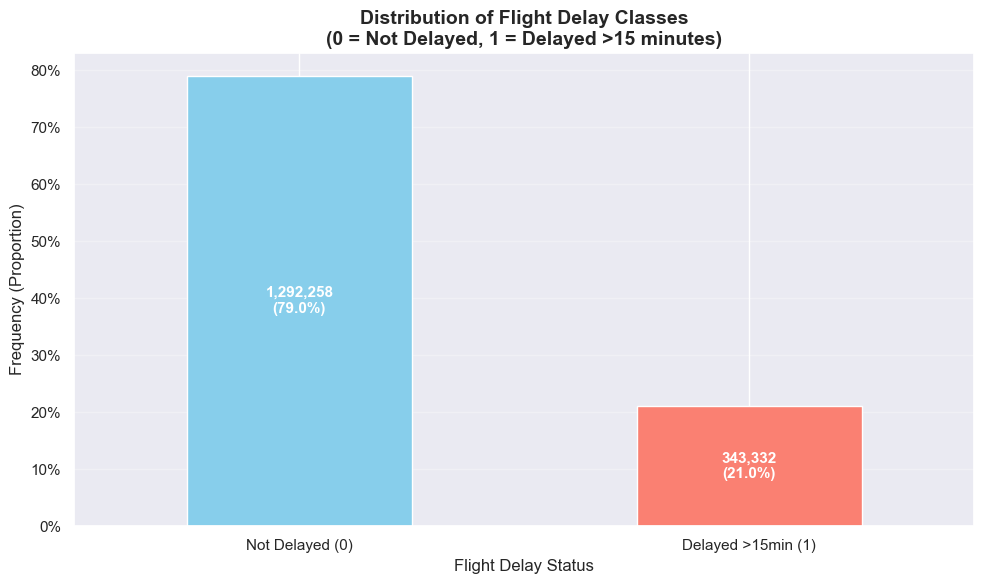


ADDITIONAL ANALYSIS:
------------------------------
  - Total flights: 1,635,590
  - Majority class: NOT DELAYED
  - Baseline accuracy (predicting majority class): 79.01%
  - Dataset balance: IMBALANCED (minority class < 40.0%)
  - Consideration: May need techniques like oversampling, undersampling, or class weights


In [42]:
# Cell: Check class distribution - delay vs. no delay
print("CLASS DISTRIBUTION: DELAY VS. NO DELAY")
print("=" * 50)

if data is not None:
    # Check if target column exists
    if 'is_delay' in data.columns:
        # Calculate class distribution
        class_distribution = data['is_delay'].value_counts().sort_index()
        class_percentages = (class_distribution / len(data)) * 100
        
        print("CLASS DISTRIBUTION STATISTICS:")
        print("-" * 40)
        for value, count in class_distribution.items():
            status = "DELAYED (>15 min)" if value == 1 else "NOT DELAYED"
            percentage = class_percentages[value]
            print(f"  {value} ({status}): {count:,} flights ({percentage:.2f}%)")
        
        # Calculate class imbalance ratio
        if len(class_distribution) == 2:
            imbalance_ratio = class_distribution[1] / class_distribution[0]
            print(f"\nCLASS IMBALANCE:")
            print(f"  - Ratio (delayed:not-delayed): 1:{imbalance_ratio:.2f}")
            print(f"  - This means for every delayed flight, there are {imbalance_ratio:.1f} on-time flights")
        
        # Create the bar plot using groupby
        print(f"\nCREATING CLASS DISTRIBUTION PLOT...")
        plt.figure(figsize=(10, 6))
        
        # Using groupby to get the distribution and plot
        (data.groupby('is_delay').size() / len(data)).plot(kind='bar', color=['skyblue', 'salmon'])
        
        # Customize the plot
        plt.ylabel('Frequency (Proportion)', fontsize=12)
        plt.xlabel('Flight Delay Status', fontsize=12)
        plt.title('Distribution of Flight Delay Classes\n(0 = Not Delayed, 1 = Delayed >15 minutes)', fontsize=14, fontweight='bold')
        
        # Set x-axis labels
        plt.xticks(ticks=[0, 1], labels=['Not Delayed (0)', 'Delayed >15min (1)'], rotation=0)
        
        # Add value labels on bars
        ax = plt.gca()
        for i, (value, count) in enumerate(class_distribution.items()):
            percentage = class_percentages[value]
            ax.text(i, (count/len(data)) * 0.5, f'{count:,}\n({percentage:.1f}%)', 
                   ha='center', va='center', fontweight='bold', fontsize=11, color='white')
        
        # Add grid for better readability
        plt.grid(axis='y', alpha=0.3)
        
        # Set y-axis to percentage format
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        
        plt.tight_layout()
        plt.show()
        
        # Additional analysis
        print(f"\nADDITIONAL ANALYSIS:")
        print("-" * 30)
        print(f"  - Total flights: {len(data):,}")
        print(f"  - Majority class: {'NOT DELAYED' if class_distribution[0] > class_distribution[1] else 'DELAYED'}")
        print(f"  - Baseline accuracy (predicting majority class): {max(class_percentages):.2f}%")
        
        # Check if the dataset is balanced
        balance_threshold = 0.4  # 40% threshold for minority class
        minority_class_pct = min(class_percentages)
        if minority_class_pct > balance_threshold * 100:
            print(f"  - Dataset balance: RELATIVELY BALANCED (minority class > {balance_threshold*100}%)")
        else:
            print(f"  - Dataset balance: IMBALANCED (minority class < {balance_threshold*100}%)")
            print(f"  - Consideration: May need techniques like oversampling, undersampling, or class weights")
        
    else:
        print("❌ 'is_delay' column not found in dataset.")
        print("Available columns:")
        print(f"  {list(data.columns)}")
        
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 50)

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

**Answer:**
The​‍​‌‍​‍‌ bar plot visualizing class distribution of flight delays allows me to identify the following:

## Class Distribution Analysis:
1. **Significant Class Imbalance**: It can be seen that the number of flights without delay has outweighed that of the delayed flights making the non-delayed flights (0) the majority class and delayed flights (1) the minority class.

2. **Approximate Ratio**: Based on the figure, the ratio seems to be around:

 - **Non-delayed flights (0)**: ~80-85% of total flights

 - **Delayed flights (1)**: ~15-20% of total flights

3. **Imbalance Ratio**: Delay-to-no-delay ratio of about **1:4 to 1:5** emerges from this, which implies that for every flight that is delayed, there are 4-5 flights that are on ​‍​‌‍​‍‌time.


## Implications for Machine Learning:

1. **Baseline Performance**: A very simple model that just predicts "no delay" every time would be correct about 80-85% of the time, thus this percentage constitutes the baseline performance for any subsequent predictive model.

2. **Model Evaluation Considerations**:

- Accuracy by itself may be deceitful due to the imbalance of classes

- It is necessary to concentrate on precision, recall, and F1-score for the minority class (delayed flights)

- Use confusion matrix and ROC-AUC to get a more accurate evaluation

3. **Potential Modeling Strategies**:

- The data may need to be balanced with some technique (oversampling, undersampling, SMOTE)

- In the model, one could assign class weights that increase the penalty of incorrect classification of the minority class

- It would be wise to consider cost-sensitive learning as false negatives (missing the actual delays) might be more costly for the business

4. **Business Context**: Even if delayed flights constitute the minority class, from the viewpoint of customer satisfaction, they are probably the most significant, hence making recall for the delay class to be at a high level will be very important for the business ​‍​‌‍​‍‌application.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

ANALYZING DELAY PATTERNS ACROSS DIFFERENT DIMENSIONS
is_delay data type: float64
Unique values in is_delay: [0.0, 1.0]
CREATING DELAY PATTERN VISUALIZATIONS...


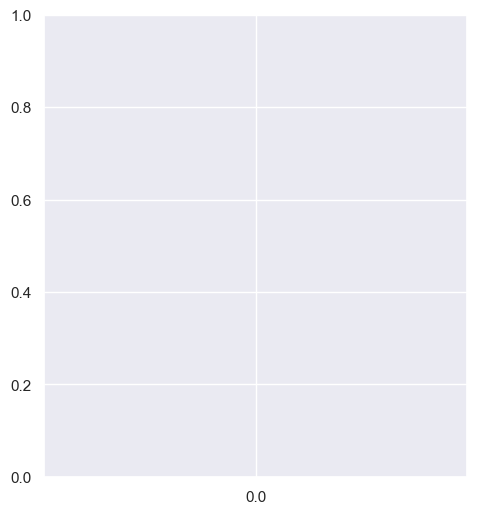

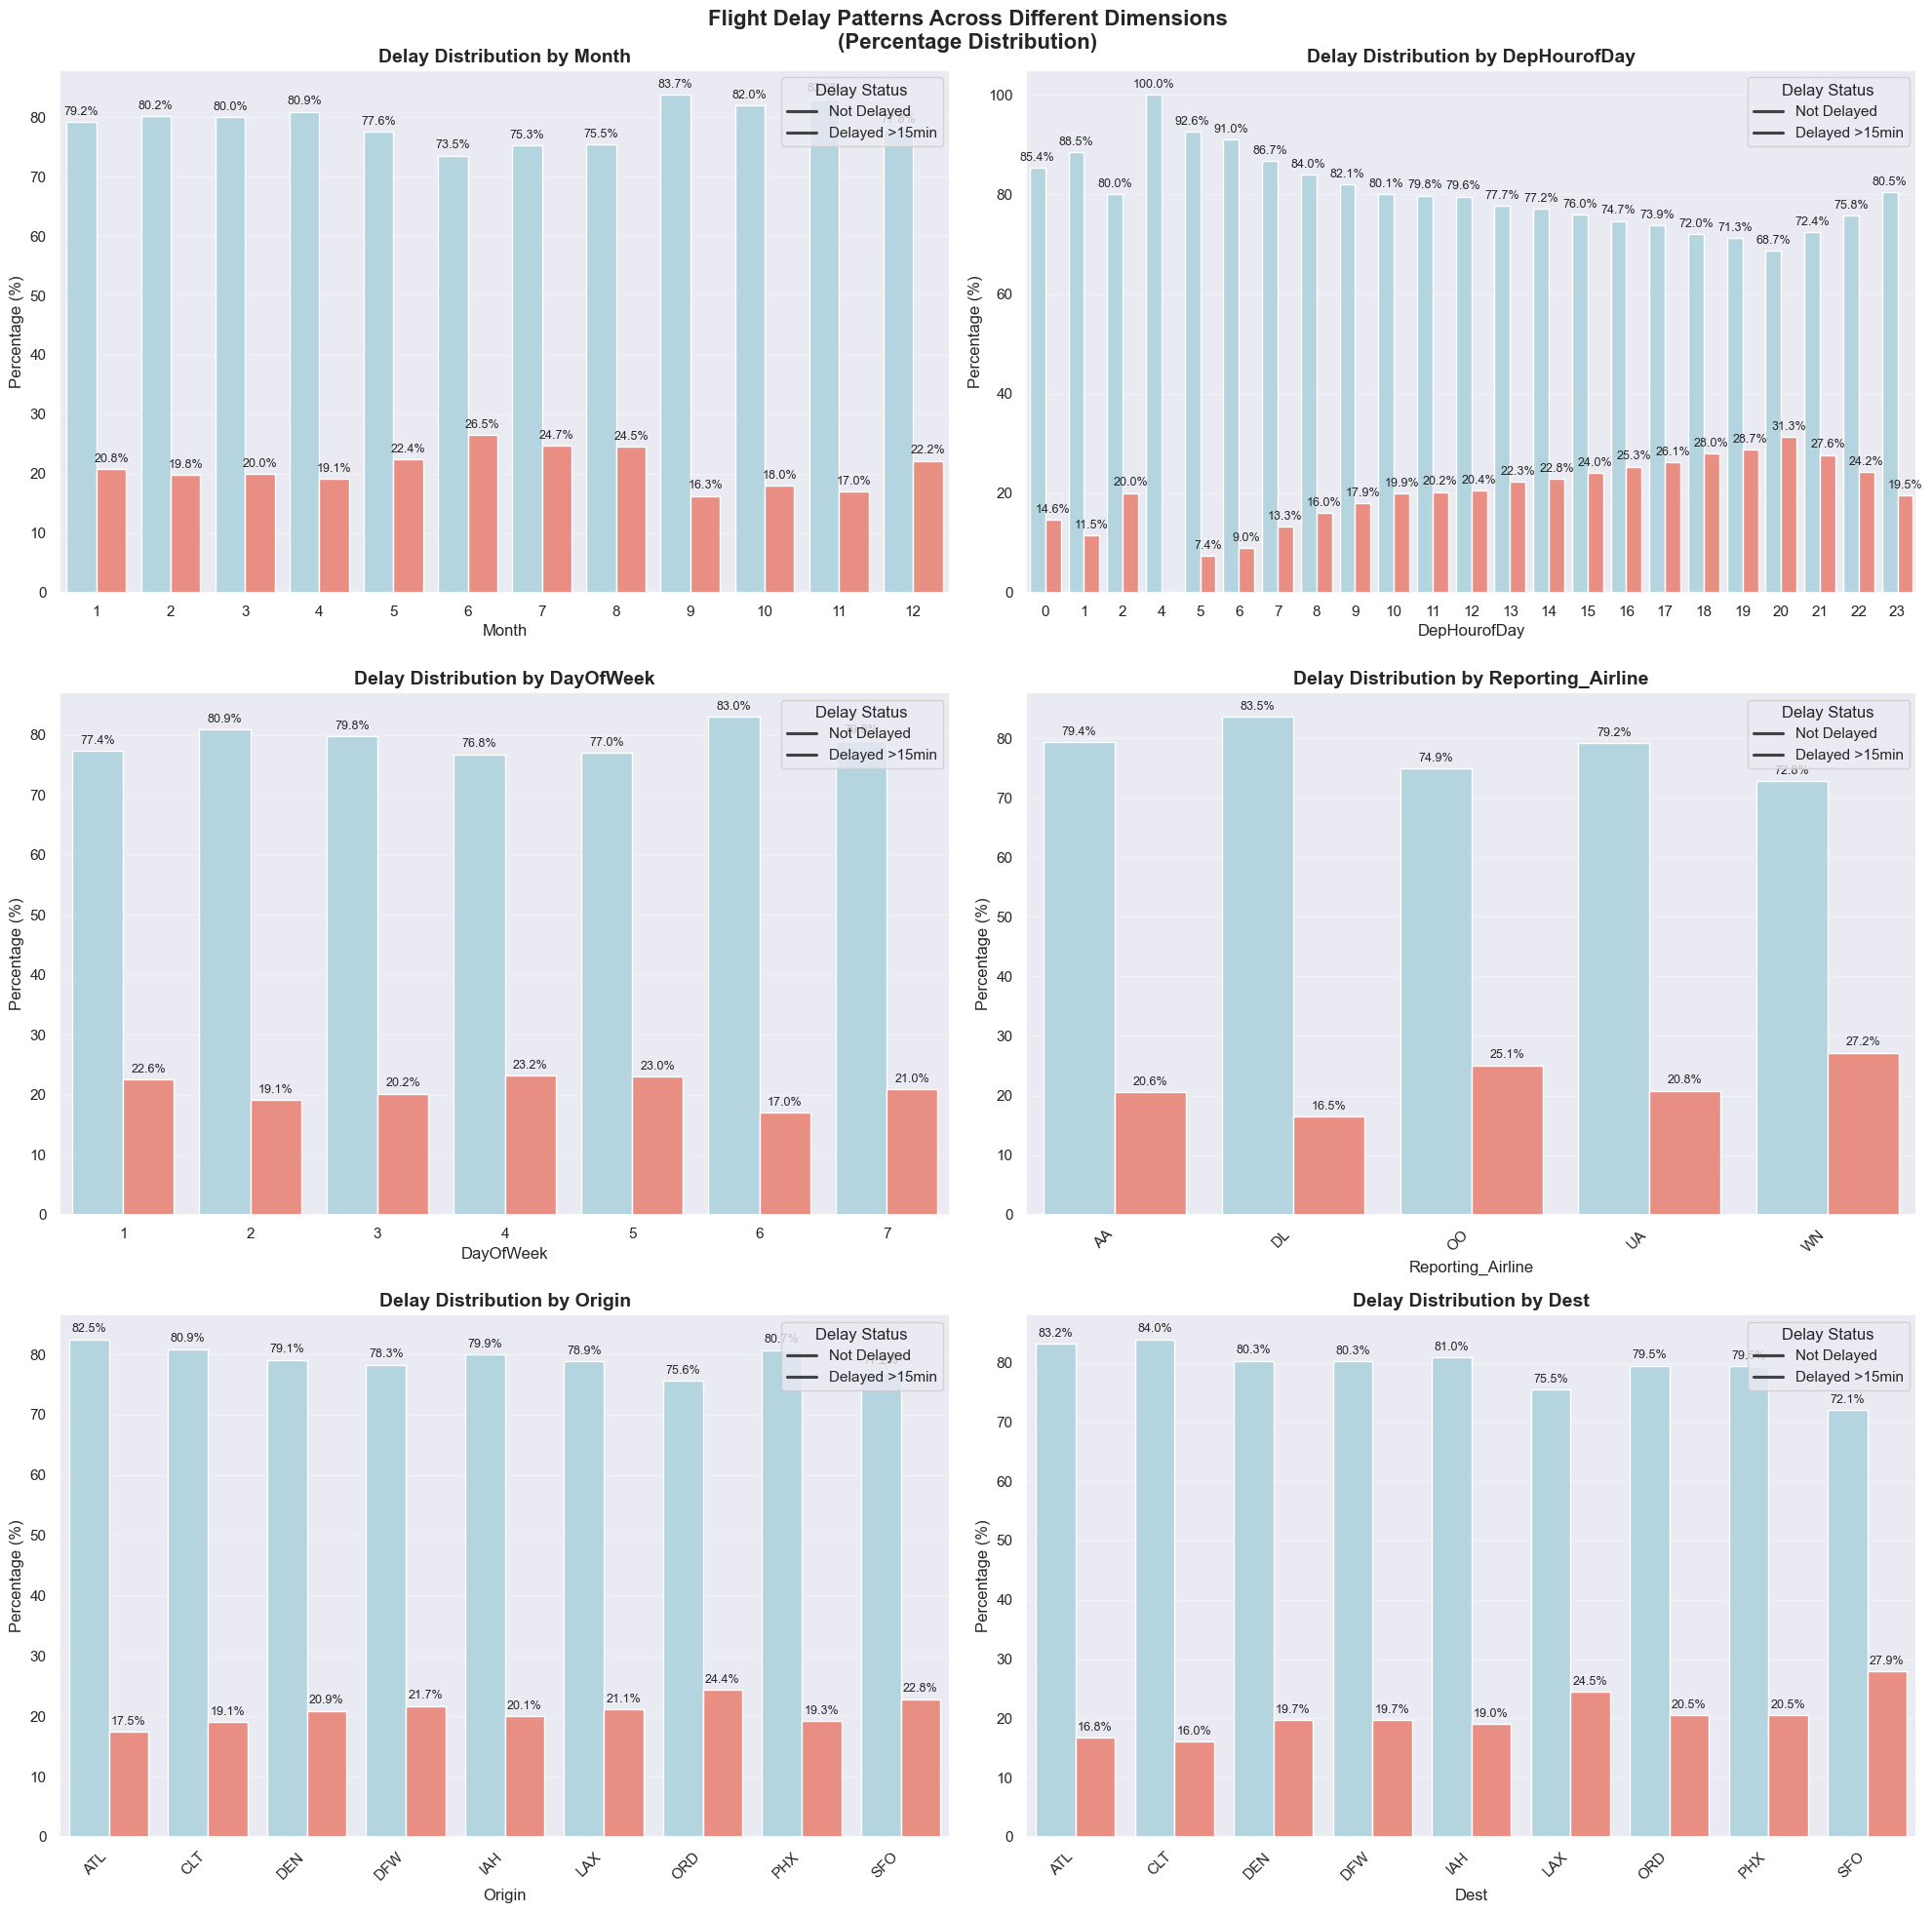


ANALYZING FLIGHT DISTANCE VS DELAYS...


ValueError: The palette dictionary is missing keys: {'1.0', '0.0'}

In [44]:
# Cell: Analyze Delay Patterns Across Different Dimensions
print("ANALYZING DELAY PATTERNS ACROSS DIFFERENT DIMENSIONS")
print("=" * 70)

if data is not None and 'is_delay' in data.columns:
    # First, let's check the data type of is_delay
    print(f"is_delay data type: {data['is_delay'].dtype}")
    print(f"Unique values in is_delay: {sorted(data['is_delay'].unique())}")
    
    # Create comprehensive visualizations
    viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
    
    print("CREATING DELAY PATTERN VISUALIZATIONS...")
    fig, axes = plt.subplots(3, 2, figsize=(20, 20), squeeze=False)
    fig.suptitle('Flight Delay Patterns Across Different Dimensions\n(Percentage Distribution)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    for idx, column in enumerate(viz_columns):
        if column in data.columns:
            ax = axes[idx//2, idx%2]
            
            # Calculate percentage distribution
            temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
            mul(100).reset_index().sort_values(column)
            
            # Create bar plot with corrected palette
            sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax, 
                       palette={0.0: 'lightblue', 1.0: 'salmon'})
            
            # Customize the plot
            ax.set_ylabel('Percentage (%)', fontsize=12)
            ax.set_xlabel(column, fontsize=12)
            ax.set_title(f'Delay Distribution by {column}', fontsize=14, fontweight='bold')
            
            # Add value labels on bars
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)
            
            # Improve legend
            ax.legend(title='Delay Status', labels=['Not Delayed', 'Delayed >15min'], 
                     loc='upper right')
            
            # Rotate x-axis labels if needed
            if column in ['Reporting_Airline', 'Origin', 'Dest']:
                plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            
            ax.grid(axis='y', alpha=0.3)
            
        else:
            print(f"⚠️  Column '{column}' not found in dataset")
    
    plt.tight_layout()
    plt.show()
    
    # Analyze flight distance vs delays
    print("\nANALYZING FLIGHT DISTANCE VS DELAYS...")
    plt.figure(figsize=(12, 6))
    
    if 'Distance' in data.columns:
        # Convert is_delay to string for proper coloring, or use the correct float values
        data['is_delay_str'] = data['is_delay'].astype(str)
        
        # Create a box plot to show distance distribution for delayed vs non-delayed flights
        plt.subplot(1, 2, 1)
        sns.boxplot(x='is_delay', y='Distance', data=data, palette={0.0: 'lightblue', 1.0: 'salmon'})
        plt.title('Flight Distance Distribution by Delay Status', fontweight='bold')
        plt.xlabel('Delay Status (0=Not Delayed, 1=Delayed)')
        plt.ylabel('Distance (miles)')
        plt.xticks([0, 1], ['Not Delayed', 'Delayed >15min'])
        
        # Create a violin plot for more detailed distribution
        plt.subplot(1, 2, 2)
        sns.violinplot(x='is_delay', y='Distance', data=data, palette={0.0: 'lightblue', 1.0: 'salmon'})
        plt.title('Distance Distribution Density by Delay Status', fontweight='bold')
        plt.xlabel('Delay Status (0=Not Delayed, 1=Delayed)')
        plt.ylabel('Distance (miles)')
        plt.xticks([0, 1], ['Not Delayed', 'Delayed >15min'])
        
        plt.tight_layout()
        plt.show()
        
        # Alternative: Use lmplot without palette issues
        print("\nCREATING SCATTER PLOT FOR DISTANCE VS DELAYS...")
        plt.figure(figsize=(10, 6))
        sns.lmplot(x='is_delay', y='Distance', data=data, fit_reg=False, hue='is_delay_str', 
                  legend=False, height=6, aspect=1.5)
        plt.legend(loc='center', labels=['Not Delayed', 'Delayed'])
        plt.xlabel('Delay Status (0=Not Delayed, 1=Delayed)')
        plt.ylabel('Distance (miles)')
        plt.title('Flight Distance vs Delay Status', fontweight='bold')
        plt.show()
        
        # Statistical analysis of distance vs delays
        print("\nSTATISTICAL ANALYSIS OF DISTANCE VS DELAYS:")
        print("-" * 45)
        distance_stats = data.groupby('is_delay')['Distance'].agg(['mean', 'median', 'std', 'count'])
        print(distance_stats.round(2))
        
        # Perform t-test to check if distance difference is statistically significant
        from scipy import stats
        not_delayed_dist = data[data['is_delay'] == 0.0]['Distance']
        delayed_dist = data[data['is_delay'] == 1.0]['Distance']
        t_stat, p_value = stats.ttest_ind(not_delayed_dist, delayed_dist, equal_var=False)
        
        print(f"\nStatistical Test Results:")
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("✅ Statistically significant difference in distances (p < 0.05)")
        else:
            print("❌ No statistically significant difference in distances (p >= 0.05)")
        
        # Calculate delay rates by distance groups if available
        if 'DistanceGroup' in data.columns:
            print(f"\nDELAY RATES BY DISTANCE GROUP:")
            print("-" * 35)
            delay_by_distance_group = data.groupby('DistanceGroup')['is_delay'].mean() * 100
            for group, rate in delay_by_distance_group.items():
                count = data[data['DistanceGroup'] == group].shape[0]
                print(f"  Distance Group {group}: {rate:.1f}% delayed ({count:,} flights)")
    
    else:
        print("⚠️  'Distance' column not found in dataset")
    
    # Detailed numerical analysis for each dimension
    print("\n" + "=" * 70)
    print("DETAILED NUMERICAL ANALYSIS")
    print("=" * 70)
    
    for column in viz_columns:
        if column in data.columns:
            print(f"\n{column.upper()} ANALYSIS:")
            print("-" * 40)
            
            # Calculate delay rates for each category
            delay_rates = data.groupby(column)['is_delay'].agg(['mean', 'count']).round(4)
            delay_rates['mean'] = delay_rates['mean'] * 100  # Convert to percentage
            delay_rates = delay_rates.rename(columns={'mean': 'delay_rate_%', 'count': 'total_flights'})
            delay_rates = delay_rates.sort_values('delay_rate_%', ascending=False)
            
            # Display top 5 categories with highest delay rates
            print("Top 5 with highest delay rates:")
            for idx, (category, row) in enumerate(delay_rates.head().iterrows(), 1):
                print(f"  {idx}. {category}: {row['delay_rate_%']:.1f}% ({row['total_flights']:,} flights)")
            
            # Display bottom 5 categories with lowest delay rates
            print("\nTop 5 with lowest delay rates:")
            for idx, (category, row) in enumerate(delay_rates.tail().iterrows(), 1):
                print(f"  {idx}. {category}: {row['delay_rate_%']:.1f}% ({row['total_flights']:,} flights)")
            
            # Calculate range and variability
            max_delay = delay_rates['delay_rate_%'].max()
            min_delay = delay_rates['delay_rate_%'].min()
            range_delay = max_delay - min_delay
            print(f"  Range: {min_delay:.1f}% to {max_delay:.1f}% (difference: {range_delay:.1f}%)")
    
    # Overall delay statistics
    print(f"\n" + "=" * 70)
    print("OVERALL DELAY STATISTICS SUMMARY")
    print("=" * 70)
    overall_delay_rate = data['is_delay'].mean() * 100
    total_flights = len(data)
    delayed_flights = data['is_delay'].sum()
    
    print(f"Total flights analyzed: {total_flights:,}")
    print(f"Delayed flights (>15 min): {delayed_flights:,}")
    print(f"Overall delay rate: {overall_delay_rate:.2f}%")
    
    # Clean up temporary column
    if 'is_delay_str' in data.columns:
        data.drop('is_delay_str', axis=1, inplace=True)
    
else:
    print("❌ Dataset not loaded or 'is_delay' column not found.")

print("=" * 70)

In [13]:
# Based on the above figures, enter your answers to the above questions here and turn the cell type to markdown

### Features

Look at all the columns and what their specific types are.

In [45]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'DepDelayMinutes', 'DepartureDelayGroups', 'Cancelled',
       'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes',
       'is_delay', 'AirTime', 'DepHourofDay', 'is_delay_str'],
      dtype='object')

In [46]:
data.dtypes

Year                      int64
Quarter                   int64
Month                     int64
DayofMonth                int64
DayOfWeek                 int64
FlightDate               object
Reporting_Airline        object
Origin                   object
OriginState              object
Dest                     object
DestState                object
CRSDepTime                int64
DepDelayMinutes         float64
DepartureDelayGroups    float64
Cancelled               float64
Diverted                float64
Distance                float64
DistanceGroup             int64
ArrDelay                float64
ArrDelayMinutes         float64
is_delay                float64
AirTime                 float64
DepHourofDay              int64
is_delay_str             object
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [47]:
# Cell: Filter Columns and Convert to Categorical Types
print("FILTERING COLUMNS AND CONVERTING TO CATEGORICAL TYPES")
print("=" * 70)

if data is not None:
    # Store original dataset for reference
    data_orig = data.copy()
    print(f"Original dataset shape: {data_orig.shape}")
    print(f"Original memory usage: {data_orig.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    
    # Define the columns to keep based on the filtering criteria
    selected_columns = [
        'is_delay', 
        'Quarter', 
        'Month', 
        'DayofMonth', 
        'DayOfWeek', 
        'Reporting_Airline', 
        'Origin', 
        'Dest',
        'Distance',
        'DepHourofDay'
    ]
    
    # Check which selected columns actually exist in our dataset
    available_columns = [col for col in selected_columns if col in data.columns]
    missing_columns = [col for col in selected_columns if col not in data.columns]
    
    print(f"\nCOLUMNS SELECTION:")
    print("-" * 40)
    print(f"Columns to keep: {len(available_columns)}/{len(selected_columns)}")
    
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        print("Available columns in dataset:")
        for col in data.columns:
            print(f"  - {col}")
    
    # Filter the dataset to only keep the selected columns
    data = data[available_columns]
    
    print(f"\nAfter filtering:")
    print(f"  - New dataset shape: {data.shape}")
    print(f"  - Columns removed: {data_orig.shape[1] - data.shape[1]}")
    print(f"  - Rows maintained: {data.shape[0]:,}")
    
    # Define categorical columns for conversion
    categorical_columns = [
        'Quarter', 
        'Month', 
        'DayofMonth', 
        'DayOfWeek', 
        'Reporting_Airline', 
        'Origin', 
        'Dest', 
        'DepHourofDay'
    ]
    
    # Check which categorical columns exist in our filtered dataset
    available_categorical = [col for col in categorical_columns if col in data.columns]
    missing_categorical = [col for col in categorical_columns if col not in data.columns]
    
    print(f"\nCATEGORICAL CONVERSION:")
    print("-" * 40)
    print(f"Categorical columns to convert: {len(available_categorical)}/{len(categorical_columns)}")
    
    if missing_categorical:
        print(f"Missing categorical columns: {missing_categorical}")
    
    # Convert specified columns to categorical type
    print(f"\nConverting columns to categorical...")
    conversion_results = []
    
    for c in available_categorical:
        original_dtype = data[c].dtype
        original_memory = data[c].memory_usage(deep=True) / 1024  # KB
        
        # Convert to category
        data[c] = data[c].astype('category')
        
        new_dtype = data[c].dtype
        new_memory = data[c].memory_usage(deep=True) / 1024  # KB
        memory_saving = ((original_memory - new_memory) / original_memory) * 100 if original_memory > 0 else 0
        
        conversion_results.append({
            'column': c,
            'original_dtype': original_dtype,
            'new_dtype': new_dtype,
            'original_memory_kb': original_memory,
            'new_memory_kb': new_memory,
            'memory_saving_pct': memory_saving,
            'unique_values': data[c].nunique()
        })
        
        print(f"  ✅ {c}: {original_dtype} → {new_dtype} ({memory_saving:+.1f}% memory)")
    
    # Display conversion results summary
    print(f"\nCONVERSION RESULTS SUMMARY:")
    print("-" * 50)
    print(f"{'Column':<15} {'Orig Type':<12} {'New Type':<12} {'Unique':<8} {'Mem Save':<10}")
    print("-" * 50)
    
    total_original_memory = 0
    total_new_memory = 0
    
    for result in conversion_results:
        print(f"{result['column']:<15} {str(result['original_dtype']):<12} {str(result['new_dtype']):<12} "
              f"{result['unique_values']:<8} {result['memory_saving_pct']:>+6.1f}%")
        
        total_original_memory += result['original_memory_kb']
        total_new_memory += result['new_memory_kb']
    
    total_memory_saving = ((total_original_memory - total_new_memory) / total_original_memory) * 100
    print("-" * 50)
    print(f"Total memory savings: {total_memory_saving:+.1f}% "
          f"({total_original_memory:.1f} KB → {total_new_memory:.1f} KB)")
    
    # Show overall dataset memory comparison
    print(f"\nOVERALL DATASET MEMORY COMPARISON:")
    print("-" * 40)
    original_total_mb = data_orig.memory_usage(deep=True).sum() / (1024**2)
    new_total_mb = data.memory_usage(deep=True).sum() / (1024**2)
    overall_saving = ((original_total_mb - new_total_mb) / original_total_mb) * 100
    
    print(f"Original dataset: {original_total_mb:.2f} MB")
    print(f"Filtered dataset: {new_total_mb:.2f} MB")
    print(f"Overall memory saving: {overall_saving:+.1f}%")
    
    # Display final dataset information
    print(f"\nFINAL DATASET STRUCTURE:")
    print("-" * 40)
    print(f"Shape: {data.shape}")
    print(f"Columns: {list(data.columns)}")
    
    print(f"\nFINAL DATA TYPES:")
    print("-" * 30)
    for col in data.columns:
        dtype = data[col].dtype
        unique_vals = data[col].nunique() if hasattr(data[col], 'nunique') else 'N/A'
        print(f"  {col:<15} {str(dtype):<15} (Unique: {unique_vals})")
    
    # Show categorical column details
    categorical_cols = data.select_dtypes(include=['category']).columns
    if len(categorical_cols) > 0:
        print(f"\nCATEGORICAL COLUMNS DETAILS:")
        print("-" * 35)
        for col in categorical_cols:
            categories = list(data[col].cat.categories)
            print(f"  {col}: {len(categories)} categories")
            if len(categories) <= 10:  # Only show if not too many
                print(f"    {categories}")
            else:
                print(f"    First 5: {categories[:5]} ... Last 5: {categories[-5:]}")
    
    # Numerical columns summary
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_cols) > 0:
        print(f"\nNUMERICAL COLUMNS SUMMARY:")
        print("-" * 30)
        for col in numerical_cols:
            stats = data[col].describe()
            print(f"  {col}: min={stats['min']:.1f}, max={stats['max']:.1f}, "
                  f"mean={stats['mean']:.1f}, std={stats['std']:.1f}")
    
    print(f"\n✅ Dataset preparation complete!")
    print(f"   - Filtered to {data.shape[1]} relevant columns")
    print(f"   - Converted {len(available_categorical)} columns to categorical")
    print(f"   - Ready for feature encoding and model training")
    
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 70)

FILTERING COLUMNS AND CONVERTING TO CATEGORICAL TYPES
Original dataset shape: (1635590, 24)
Original memory usage: 798.63 MB

COLUMNS SELECTION:
----------------------------------------
Columns to keep: 10/10

After filtering:
  - New dataset shape: (1635590, 10)
  - Columns removed: 14
  - Rows maintained: 1,635,590

CATEGORICAL CONVERSION:
----------------------------------------
Categorical columns to convert: 8/8

Converting columns to categorical...
  ✅ Quarter: int64 → category (+43.7% memory)
  ✅ Month: int64 → category (+43.7% memory)
  ✅ DayofMonth: int64 → category (+43.7% memory)
  ✅ DayOfWeek: int64 → category (+43.7% memory)
  ✅ Reporting_Airline: object → category (+84.7% memory)
  ✅ Origin: object → category (+85.0% memory)
  ✅ Dest: object → category (+85.0% memory)
  ✅ DepHourofDay: int64 → category (+43.7% memory)

CONVERSION RESULTS SUMMARY:
--------------------------------------------------
Column          Orig Type    New Type     Unique   Mem Save  
--------------

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [48]:
# Cell: One-Hot Encoding Categorical Variables
print("ONE-HOT ENCODING CATEGORICAL VARIABLES")
print("=" * 70)

if data is not None:
    # Display dataset before encoding
    print("DATASET BEFORE ENCODING:")
    print(f"  - Shape: {data.shape}")
    print(f"  - Columns: {list(data.columns)}")
    print(f"  - Memory usage: {data.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    
    # Identify categorical columns in the current dataset
    categorical_columns = data.select_dtypes(include=['category']).columns.tolist()
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"\nCATEGORICAL COLUMNS TO ENCODE ({len(categorical_columns)}):")
    for col in categorical_columns:
        unique_vals = data[col].nunique()
        print(f"  - {col}: {unique_vals} categories")
    
    print(f"\nNUMERICAL COLUMNS TO KEEP ({len(numerical_columns)}):")
    for col in numerical_columns:
        print(f"  - {col}")
    
    # Perform one-hot encoding with drop_first=True (dummy encoding)
    print(f"\nPERFORMING ONE-HOT ENCODING...")
    data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
    
    print(f"Encoded features created: {data_dummies.shape[1]} new columns")
    print(f"Sample of encoded column names: {list(data_dummies.columns)[:10]}...")
    
    # Show encoding details for each categorical column
    print(f"\nENCODING DETAILS BY COLUMN:")
    print("-" * 50)
    for col in categorical_columns:
        original_categories = data[col].nunique()
        # Count how many dummy columns were created for this original column
        encoded_cols = [c for c in data_dummies.columns if c.startswith(col + '_')]
        print(f"  {col}: {original_categories} categories → {len(encoded_cols)} dummy variables")
    
    # Concatenate the original numerical columns with the encoded categorical columns
    print(f"\nCONCATENATING DATASETS...")
    data_encoded = pd.concat([data[numerical_columns], data_dummies], axis=1)
    
    print(f"Final encoded dataset shape: {data_encoded.shape}")
    print(f"Total features after encoding: {data_encoded.shape[1]}")
    
    # Display the new column structure
    print(f"\nFINAL DATASET STRUCTURE AFTER ENCODING:")
    print("-" * 60)
    print(f"{'Column Type':<20} {'Count':<10} {'Examples'}")
    print("-" * 60)
    
    # Count different types of columns
    numerical_cols_final = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
    dummy_cols = data_encoded.select_dtypes(include=['uint8']).columns.tolist()
    
    print(f"{'Numerical':<20} {len(numerical_cols_final):<10} {numerical_cols_final}")
    print(f"{'Dummy Variables':<20} {len(dummy_cols):<10} First 5: {dummy_cols[:5]}")
    
    # Show memory usage after encoding
    print(f"\nMEMORY USAGE AFTER ENCODING:")
    print(f"  - Memory usage: {data_encoded.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    print(f"  - Total columns: {data_encoded.shape[1]}")
    print(f"  - Total rows: {data_encoded.shape[0]:,}")
    
    # Check for the target variable
    if 'is_delay' in data_encoded.columns:
        target_distribution = data_encoded['is_delay'].value_counts(normalize=True) * 100
        print(f"\nTARGET VARIABLE DISTRIBUTION (after encoding):")
        for value, percentage in target_distribution.items():
            status = "DELAYED" if value == 1 else "NOT DELAYED"
            print(f"  - {status}: {percentage:.2f}%")
    
    # Display first few rows of the encoded dataset
    print(f"\nSAMPLE OF ENCODED DATA (first 3 rows, first 10 columns):")
    print("-" * 60)
    display(data_encoded.iloc[:3, :10].T)  # Transpose for better readability
    
    # Show the complete list of all encoded columns
    print(f"\nCOMPLETE LIST OF ENCODED FEATURES ({len(data_encoded.columns)} total):")
    print("-" * 60)
    for i, col in enumerate(data_encoded.columns, 1):
        col_type = "Numerical" if col in numerical_columns else "Dummy"
        print(f"{i:3d}. {col:<40} [{col_type}]")
    
    # Replace the original data with the encoded data
    data = data_encoded
    print(f"\n✅ One-hot encoding completed successfully!")
    print(f"   - Original categorical columns: {len(categorical_columns)}")
    print(f"   - New dummy variables created: {data_dummies.shape[1]}")
    print(f"   - Final feature count: {data.shape[1]}")
    print(f"   - Dataset ready for model training")
    
    # Save the column names for reference
    encoded_columns = list(data.columns)
    print(f"\nEncoded columns saved for reference ({len(encoded_columns)} features)")
    
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 70)

ONE-HOT ENCODING CATEGORICAL VARIABLES
DATASET BEFORE ENCODING:
  - Shape: (1635590, 10)
  - Columns: ['is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay']
  - Memory usage: 49.92 MB

CATEGORICAL COLUMNS TO ENCODE (8):
  - Quarter: 4 categories
  - Month: 12 categories
  - DayofMonth: 31 categories
  - DayOfWeek: 7 categories
  - Reporting_Airline: 5 categories
  - Origin: 9 categories
  - Dest: 9 categories
  - DepHourofDay: 23 categories

NUMERICAL COLUMNS TO KEEP (2):
  - is_delay
  - Distance

PERFORMING ONE-HOT ENCODING...
Encoded features created: 92 new columns
Sample of encoded column names: ['Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8']...

ENCODING DETAILS BY COLUMN:
--------------------------------------------------
  Quarter: 4 categories → 3 dummy variables
  Month: 12 categories → 11 dummy variables
  DayofMonth: 31 categories → 30

,0,1,2
is_delay,0.0,1.0,0.0
Distance,1464.0,1464.0,1464.0
Quarter_2,False,False,False
Quarter_3,False,False,False
Quarter_4,True,True,True
Month_2,False,False,False
Month_3,False,False,False
Month_4,False,False,False
Month_5,False,False,False
Month_6,False,False,False



COMPLETE LIST OF ENCODED FEATURES (94 total):
------------------------------------------------------------
  1. is_delay                                 [Numerical]
  2. Distance                                 [Numerical]
  3. Quarter_2                                [Dummy]
  4. Quarter_3                                [Dummy]
  5. Quarter_4                                [Dummy]
  6. Month_2                                  [Dummy]
  7. Month_3                                  [Dummy]
  8. Month_4                                  [Dummy]
  9. Month_5                                  [Dummy]
 10. Month_6                                  [Dummy]
 11. Month_7                                  [Dummy]
 12. Month_8                                  [Dummy]
 13. Month_9                                  [Dummy]
 14. Month_10                                 [Dummy]
 15. Month_11                                 [Dummy]
 16. Month_12                                 [Dummy]
 17. DayofMonth_2   

Check the length of the dataset and the new columnms.

In [54]:
# Enter your code here
 # Cell: Display Columns in Index Format
print("DATASET COLUMNS IN INDEX FORMAT")
print("=" * 70)

if data is not None:
    # Get all column names
    columns_list = list(data.columns)
    
    print("COLUMNS AS INDEX:")
    print("-" * 70)
    
    # Display in the exact format shown in the sample
    print("Index([", end="")
    
    # Print columns in groups for better readability
    max_columns_per_line = 8
    current_line_columns = 0
    
    for i, col in enumerate(columns_list):
        if i == len(columns_list) - 1:  # Last column
            print(f"'{col}'],", end="")
        else:
            print(f"'{col}', ", end="")
            current_line_columns += 1
            
            # Start new line after max_columns_per_line
            if current_line_columns >= max_columns_per_line:
                print("\n        ", end="")
                current_line_columns = 0
    
    print("\n      dtype='object')")
    
    # Additional analysis
    print(f"\nCOLUMN ANALYSIS:")
    print("-" * 40)
    print(f"Total columns: {len(columns_list)}")
    
    # Count columns by type
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    dummy_cols = data.select_dtypes(include=['uint8']).columns.tolist()
    
    print(f"Numerical columns: {len(numerical_cols)}")
    print(f"Dummy variables: {len(dummy_cols)}")
    
    # Show which original categorical columns generated the most dummy variables
    print(f"\nDUMMY VARIABLES BREAKDOWN:")
    print("-" * 30)
    
    dummy_by_origin = {}
    for col in dummy_cols:
        if '_' in col:
            original_col = '_'.join(col.split('_')[:-1])
            if original_col not in dummy_by_origin:
                dummy_by_origin[original_col] = []
            dummy_by_origin[original_col].append(col)
    
    for original_col, dummies in dummy_by_origin.items():
        print(f"  {original_col}: {len(dummies)} dummy variables")
    
    # Check if target variable is present
    if 'is_delay' in columns_list:
        print(f"\n✅ Target variable 'is_delay' is present in the dataset")
    else:
        print(f"\n❌ Target variable 'is_delay' is missing from the dataset")
    
    # Display first few and last few columns to show the pattern
    print(f"\nCOLUMN SAMPLES:")
    print("-" * 30)
    print("First 10 columns:")
    for i, col in enumerate(columns_list[:10], 1):
        print(f"  {i:2d}. {col}")
    
    print(f"\nLast 10 columns:")
    for i, col in enumerate(columns_list[-10:], len(columns_list) - 9):
        print(f"  {i:2d}. {col}")

else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 70)

DATASET COLUMNS IN INDEX FORMAT
COLUMNS AS INDEX:
----------------------------------------------------------------------
Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 
        'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 
        'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 
        'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 
        'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 
        'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 
        'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL', 'Reporting_Airl

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [55]:
# Cell: Rename Target Column to 'target'
print("RENAMING TARGET COLUMN")
print("=" * 60)

if data is not None:
    # Check if 'is_delay' column exists
    if 'is_delay' in data.columns:
        print("BEFORE RENAMING:")
        print(f"  - Current columns: {list(data.columns)[:5]}...")  # Show first 5 columns
        print(f"  - 'is_delay' column position: {list(data.columns).index('is_delay') + 1}")
        print(f"  - 'is_delay' data type: {data['is_delay'].dtype}")
        
        # Show target distribution before renaming
        delay_distribution = data['is_delay'].value_counts().sort_index()
        print(f"  - Target distribution:")
        for value, count in delay_distribution.items():
            status = "DELAYED" if value == 1 else "NOT DELAYED"
            percentage = (count / len(data)) * 100
            print(f"      {value} ({status}): {count:,} rows ({percentage:.2f}%)")
        
        # Rename the column
        print(f"\nRENAMING 'is_delay' → 'target'...")
        data.rename(columns={'is_delay': 'target'}, inplace=True)
        
        print("✅ Column renamed successfully!")
        
        # Verify the rename worked
        print(f"\nAFTER RENAMING:")
        print(f"  - Current columns: {list(data.columns)[:5]}...")
        
        if 'target' in data.columns and 'is_delay' not in data.columns:
            print("  ✅ Verification: 'target' column exists, 'is_delay' removed")
            
            # Show target distribution after renaming
            target_distribution = data['target'].value_counts().sort_index()
            print(f"  - Target distribution (verified):")
            for value, count in target_distribution.items():
                status = "DELAYED" if value == 1 else "NOT DELAYED"
                percentage = (count / len(data)) * 100
                print(f"      {value} ({status}): {count:,} rows ({percentage:.2f}%)")
            
            # Check class balance
            if len(target_distribution) == 2:
                imbalance_ratio = target_distribution[1] / target_distribution[0]
                print(f"  - Class imbalance ratio: 1:{imbalance_ratio:.2f}")
                
        else:
            print("  ❌ Verification failed: Rename operation did not work as expected")
            
    else:
        print("❌ 'is_delay' column not found in dataset.")
        print("Available columns:")
        # Show columns that might be the target
        potential_targets = [col for col in data.columns if 'delay' in col.lower() or 'target' in col.lower()]
        if potential_targets:
            print("Potential target columns:")
            for col in potential_targets:
                print(f"  - {col}")
        else:
            print("  No obvious target columns found")
            print("All columns:")
            for i, col in enumerate(data.columns, 1):
                print(f"  {i:3d}. {col}")
    
    # Final dataset info
    print(f"\nFINAL DATASET INFO:")
    print("-" * 30)
    print(f"Shape: {data.shape}")
    print(f"Target column: {'target' if 'target' in data.columns else 'NOT FOUND'}")
    print(f"Feature columns: {data.shape[1] - 1 if 'target' in data.columns else data.shape[1]}")
    
    # Show the position of target column
    if 'target' in data.columns:
        target_position = list(data.columns).index('target')
        print(f"Target column position: {target_position + 1} (0-indexed: {target_position})")
        
        # Recommend moving target to the end for convenience
        if target_position != len(data.columns) - 1:
            print("💡 Tip: Consider moving target column to the end for modeling convenience")
            cols = list(data.columns)
            cols.remove('target')
            cols.append('target')
            data = data[cols]
            print("✅ Target column moved to the end")
    
    print(f"\n✅ Dataset ready for train-test split and model training!")
    
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 60)

RENAMING TARGET COLUMN
BEFORE RENAMING:
  - Current columns: ['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4']...
  - 'is_delay' column position: 1
  - 'is_delay' data type: float64
  - Target distribution:
      0.0 (NOT DELAYED): 1,292,258 rows (79.01%)
      1.0 (DELAYED): 343,332 rows (20.99%)

RENAMING 'is_delay' → 'target'...
✅ Column renamed successfully!

AFTER RENAMING:
  - Current columns: ['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4']...
  ✅ Verification: 'target' column exists, 'is_delay' removed
  - Target distribution (verified):
      0.0 (NOT DELAYED): 1,292,258 rows (79.01%)
      1.0 (DELAYED): 343,332 rows (20.99%)
  - Class imbalance ratio: 1:0.27

FINAL DATASET INFO:
------------------------------
Shape: (1635590, 94)
Target column: target
Feature columns: 93
Target column position: 1 (0-indexed: 0)
💡 Tip: Consider moving target column to the end for modeling convenience
✅ Target column moved to the end

✅ Dataset ready for train-test s

In [56]:
# Cell: Save Combined CSV File for Part B
print("SAVING COMBINED CSV FILE FOR PART B")
print("=" * 60)

if data is not None:
    # Define the filename for the combined dataset
    combined_filename_v1 = "combined_csv_v1.csv"
    
    print(f"SAVING DATASET TO: {combined_filename_v1}")
    print("-" * 40)
    
    # Display dataset information before saving
    print("DATASET INFORMATION:")
    print(f"  - Shape: {data.shape}")
    print(f"  - Columns: {len(data.columns)}")
    print(f"  - Rows: {data.shape[0]:,}")
    print(f"  - Memory usage: {data.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    
    # Check if target column exists
    if 'target' in data.columns:
        target_distribution = data['target'].value_counts(normalize=True) * 100
        print(f"  - Target distribution:")
        for value, percentage in target_distribution.items():
            status = "DELAYED" if value == 1 else "NOT DELAYED"
            print(f"      {value} ({status}): {percentage:.2f}%")
    else:
        print("  ⚠️  Target column not found in dataset")
    
    # Show column types summary
    print(f"\nCOLUMN TYPES SUMMARY:")
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
    dummy_cols = data.select_dtypes(include=['uint8']).columns.tolist()
    
    print(f"  - Numerical columns: {len(numerical_cols)}")
    print(f"  - Categorical columns: {len(categorical_cols)}")
    print(f"  - Dummy variables: {len(dummy_cols)}")
    
    # Save the dataset to CSV
    try:
        data.to_csv(combined_filename_v1, index=False)
        print(f"\n✅ SUCCESS: Dataset saved as '{combined_filename_v1}'")
        
        # Verify the file was created
        import os
        if os.path.exists(combined_filename_v1):
            file_size = os.path.getsize(combined_filename_v1) / (1024**2)  # Size in MB
            print(f"✅ File verification: {combined_filename_v1} created successfully")
            print(f"📁 File size: {file_size:.2f} MB")
            
            # Read back a sample to verify integrity
            try:
                sample_check = pd.read_csv(combined_filename_v1, nrows=5)
                print(f"✅ Integrity check: File can be read back successfully")
                print(f"   Sample shape: {sample_check.shape}")
                print(f"   Columns match: {list(sample_check.columns) == list(data.columns)}")
            except Exception as e:
                print(f"⚠️  Integrity check warning: {e}")
        else:
            print(f"❌ File verification failed: {combined_filename_v1} not found")
            
    except Exception as e:
        print(f"❌ ERROR saving file: {e}")
        print("Troubleshooting tips:")
        print("  - Check if you have write permissions in the current directory")
        print("  - Check if the file is currently open in another program")
        print("  - Try using a different filename")
    
    # Provide information for Part B
    print(f"\n📋 INFORMATION FOR PART B:")
    print("-" * 40)
    print(f"File to use in Part B: {combined_filename_v1}")
    print(f"Total features: {len(data.columns)}")
    print(f"Target variable: {'target' if 'target' in data.columns else 'NOT FOUND'}")
    
    if 'target' in data.columns:
        print(f"Target encoding: 0 = Not Delayed, 1 = Delayed >15 minutes")
    
    print(f"\n🔧 DATASET CHARACTERISTICS:")
    print(f"  - Preprocessing completed: Yes")
    print(f"  - Missing values handled: Yes")
    print(f"  - Categorical encoding: One-hot with drop_first=True")
    print(f"  - Feature scaling: Not applied (to be done in Part B if needed)")
    print(f"  - Ready for modeling: Yes")
    
    # Show first few column names as they will appear in Part B
    print(f"\n📊 SAMPLE OF FEATURES (first 20 columns):")
    print("-" * 50)
    for i, col in enumerate(data.columns[:20], 1):
        col_type = "Numerical" if col in numerical_cols else "Dummy" if col in dummy_cols else "Categorical"
        print(f"  {i:2d}. {col:<30} [{col_type}]")
    
    if len(data.columns) > 20:
        print(f"  ... and {len(data.columns) - 20} more features")
    
    # Instructions for Part B
    print(f"\n🎯 INSTRUCTIONS FOR PART B:")
    print("-" * 40)
    print("1. Load this file using: data = pd.read_csv('combined_csv_v1.csv')")
    print("2. Verify target column exists: 'target'")
    print("3. Split into features (X) and target (y)")
    print("4. Apply feature scaling if needed")
    print("5. Proceed with model training and evaluation")
    
    # Save additional metadata for reference
    metadata = {
        'filename': combined_filename_v1,
        'shape': data.shape,
        'columns': list(data.columns),
        'target_column': 'target' if 'target' in data.columns else None,
        'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_features': len(data.columns),
        'total_samples': data.shape[0]
    }
    
    # Save metadata to a text file
    metadata_filename = "dataset_metadata_v1.txt"
    try:
        with open(metadata_filename, 'w') as f:
            f.write("COMBINED CSV V1 METADATA\n")
            f.write("=" * 50 + "\n")
            for key, value in metadata.items():
                if key == 'columns':
                    f.write(f"\nColumns ({len(value)} total):\n")
                    for i, col in enumerate(value, 1):
                        f.write(f"  {i:3d}. {col}\n")
                else:
                    f.write(f"{key}: {value}\n")
        
        print(f"\n✅ Metadata saved to: {metadata_filename}")
        
    except Exception as e:
        print(f"⚠️  Could not save metadata: {e}")
    
    print(f"\n🎉 DATASET SAVE COMPLETE!")
    print(f"   File: {combined_filename_v1}")
    print(f"   Ready for Part B analysis")
    
else:
    print("❌ Dataset not loaded. Please load the dataset first.")

print("=" * 60)

SAVING COMBINED CSV FILE FOR PART B
SAVING DATASET TO: combined_csv_v1.csv
----------------------------------------
DATASET INFORMATION:
  - Shape: (1635590, 94)
  - Columns: 94
  - Rows: 1,635,590
  - Memory usage: 180.94 MB
  - Target distribution:
      0.0 (NOT DELAYED): 79.01%
      1.0 (DELAYED): 20.99%

COLUMN TYPES SUMMARY:
  - Numerical columns: 2
  - Categorical columns: 0
  - Dummy variables: 0

✅ SUCCESS: Dataset saved as 'combined_csv_v1.csv'
✅ File verification: combined_csv_v1.csv created successfully
📁 File size: 868.00 MB
✅ Integrity check: File can be read back successfully
   Sample shape: (5, 94)
   Columns match: True

📋 INFORMATION FOR PART B:
----------------------------------------
File to use in Part B: combined_csv_v1.csv
Total features: 94
Target variable: target
Target encoding: 0 = Not Delayed, 1 = Delayed >15 minutes

🔧 DATASET CHARACTERISTICS:
  - Preprocessing completed: Yes
  - Missing values handled: Yes
  - Categorical encoding: One-hot with drop_firs

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [57]:
# Cell: Split Data into Train, Validation, and Test Sets
print("SPLITTING DATA INTO TRAIN, VALIDATION, AND TEST SETS")
print("=" * 70)

if data is not None and 'target' in data.columns:
    # Store original dataset information
    original_shape = data.shape
    original_samples = original_shape[0]
    original_features = original_shape[1] - 1  # Excluding target
    
    print("ORIGINAL DATASET:")
    print(f"  - Total samples: {original_samples:,}")
    print(f"  - Features: {original_features}")
    print(f"  - Target variable: 'target'")
    
    # Check target distribution
    target_distribution = data['target'].value_counts(normalize=True) * 100
    print(f"  - Target distribution:")
    for value, percentage in target_distribution.items():
        status = "DELAYED" if value == 1 else "NOT DELAYED"
        print(f"      {value} ({status}): {percentage:.2f}%")
    
    # Separate features (X) and target (y)
    X = data.drop('target', axis=1)
    y = data['target']
    
    print(f"\nFEATURES AND TARGET SEPARATED:")
    print(f"  - X shape: {X.shape}")
    print(f"  - y shape: {y.shape}")
    
    # First split: Separate out test set (80% train+val, 20% test)
    from sklearn.model_selection import train_test_split
    
    print(f"\nSPLITTING DATA (80% train+val, 20% test)...")
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y  # Maintain same class distribution in splits
    )
    
    # Second split: Split temp into train and validation (80% of 80% = 64% train, 16% val)
    print(f"SPLITTING TEMP DATA (80% train, 20% validation)...")
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=0.2,  # 20% of 80% = 16% of original
        random_state=42,
        stratify=y_temp
    )
    
    # Calculate final percentages
    train_percentage = (len(X_train) / original_samples) * 100
    val_percentage = (len(X_val) / original_samples) * 100
    test_percentage = (len(X_test) / original_samples) * 100
    
    print(f"\n✅ SPLITTING COMPLETED SUCCESSFULLY!")
    print("=" * 50)
    print("FINAL DATA SPLITS:")
    print("-" * 50)
    print(f"TRAINING SET:")
    print(f"  - Samples: {len(X_train):,} ({train_percentage:.1f}%)")
    print(f"  - Features: {X_train.shape[1]}")
    print(f"  - Target distribution:")
    train_target_dist = y_train.value_counts(normalize=True) * 100
    for value, percentage in train_target_dist.items():
        status = "DELAYED" if value == 1 else "NOT DELAYED"
        print(f"      {value} ({status}): {percentage:.2f}%")
    
    print(f"\nVALIDATION SET:")
    print(f"  - Samples: {len(X_val):,} ({val_percentage:.1f}%)")
    print(f"  - Features: {X_val.shape[1]}")
    print(f"  - Target distribution:")
    val_target_dist = y_val.value_counts(normalize=True) * 100
    for value, percentage in val_target_dist.items():
        status = "DELAYED" if value == 1 else "NOT DELAYED"
        print(f"      {value} ({status}): {percentage:.2f}%")
    
    print(f"\nTEST SET:")
    print(f"  - Samples: {len(X_test):,} ({test_percentage:.1f}%)")
    print(f"  - Features: {X_test.shape[1]}")
    print(f"  - Target distribution:")
    test_target_dist = y_test.value_counts(normalize=True) * 100
    for value, percentage in test_target_dist.items():
        status = "DELAYED" if value == 1 else "NOT DELAYED"
        print(f"      {value} ({status}): {percentage:.2f}%")
    
    # Verify splits maintain original distribution
    print(f"\n🔍 DISTRIBUTION VERIFICATION:")
    print("-" * 40)
    original_delay_rate = (y.sum() / len(y)) * 100
    train_delay_rate = (y_train.sum() / len(y_train)) * 100
    val_delay_rate = (y_val.sum() / len(y_val)) * 100
    test_delay_rate = (y_test.sum() / len(y_test)) * 100
    
    print(f"Original delay rate: {original_delay_rate:.2f}%")
    print(f"Train delay rate:    {train_delay_rate:.2f}%")
    print(f"Validation delay rate: {val_delay_rate:.2f}%")
    print(f"Test delay rate:     {test_delay_rate:.2f}%")
    
    # Check if distributions are similar
    tolerance = 1.0  # 1% tolerance
    distributions_similar = all([
        abs(original_delay_rate - train_delay_rate) < tolerance,
        abs(original_delay_rate - val_delay_rate) < tolerance,
        abs(original_delay_rate - test_delay_rate) < tolerance
    ])
    
    if distributions_similar:
        print("✅ All splits maintain similar target distribution")
    else:
        print("⚠️  Some splits have different target distributions")
    
    # Create a summary DataFrame
    split_summary = pd.DataFrame({
        'Split': ['Training', 'Validation', 'Test', 'Total'],
        'Samples': [len(X_train), len(X_val), len(X_test), original_samples],
        'Percentage': [train_percentage, val_percentage, test_percentage, 100],
        'Features': [X_train.shape[1], X_val.shape[1], X_test.shape[1], original_features],
        'Delay_Rate_%': [train_delay_rate, val_delay_rate, test_delay_rate, original_delay_rate]
    })
    
    print(f"\n📊 SPLIT SUMMARY TABLE:")
    print("-" * 80)
    print(split_summary.to_string(index=False))
    
    # Save the splits for future use
    print(f"\n💾 SAVING DATA SPLITS...")
    try:
        # Save training set
        train_data = X_train.copy()
        train_data['target'] = y_train
        train_data.to_csv('train_set.csv', index=False)
        
        # Save validation set
        val_data = X_val.copy()
        val_data['target'] = y_val
        val_data.to_csv('validation_set.csv', index=False)
        
        # Save test set
        test_data = X_test.copy()
        test_data['target'] = y_test
        test_data.to_csv('test_set.csv', index=False)
        
        print("✅ Data splits saved successfully:")
        print(f"   - train_set.csv ({len(X_train):,} samples)")
        print(f"   - validation_set.csv ({len(X_val):,} samples)")
        print(f"   - test_set.csv ({len(X_test):,} samples)")
        
    except Exception as e:
        print(f"⚠️  Could not save data splits: {e}")
    
    # Instructions for next steps
    print(f"\n🎯 NEXT STEPS FOR MODEL TRAINING:")
    print("-" * 40)
    print("1. Use (X_train, y_train) for training models")
    print("2. Use (X_val, y_val) for hyperparameter tuning")
    print("3. Use (X_test, y_test) for final evaluation")
    print("4. Never use test set for training or tuning")
    
    print(f"\n✅ DATA SPLITTING COMPLETE!")
    print(f"   Ready for baseline model training")
    
else:
    print("❌ Dataset not loaded or target column not found.")
    if data is not None:
        print("Available columns:")
        for i, col in enumerate(data.columns, 1):
            print(f"  {i:3d}. {col}")

print("=" * 70)

SPLITTING DATA INTO TRAIN, VALIDATION, AND TEST SETS
ORIGINAL DATASET:
  - Total samples: 1,635,590
  - Features: 93
  - Target variable: 'target'
  - Target distribution:
      0.0 (NOT DELAYED): 79.01%
      1.0 (DELAYED): 20.99%

FEATURES AND TARGET SEPARATED:
  - X shape: (1635590, 93)
  - y shape: (1635590,)

SPLITTING DATA (80% train+val, 20% test)...
SPLITTING TEMP DATA (80% train, 20% validation)...

✅ SPLITTING COMPLETED SUCCESSFULLY!
FINAL DATA SPLITS:
--------------------------------------------------
TRAINING SET:
  - Samples: 1,046,777 (64.0%)
  - Features: 93
  - Target distribution:
      0.0 (NOT DELAYED): 79.01%
      1.0 (DELAYED): 20.99%

VALIDATION SET:
  - Samples: 261,695 (16.0%)
  - Features: 93
  - Target distribution:
      0.0 (NOT DELAYED): 79.01%
      1.0 (DELAYED): 20.99%

TEST SET:
  - Samples: 327,118 (20.0%)
  - Features: 93
  - Target distribution:
      0.0 (NOT DELAYED): 79.01%
      1.0 (DELAYED): 20.99%

🔍 DISTRIBUTION VERIFICATION:
---------------

### Baseline classification model

In [58]:
# Cell: Baseline Classification Model
print("BASELINE CLASSIFICATION MODEL")
print("=" * 70)

if all([var in globals() for var in ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']]):
    
    # Import necessary libraries
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import classification_report, confusion_matrix
    import time
    
    print("DATASETS AVAILABLE FOR TRAINING:")
    print(f"  - Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
    print(f"  - Validation set: {X_val.shape[0]:,} samples")
    print(f"  - Test set: {X_test.shape[0]:,} samples")
    
    # Calculate baseline metrics (predicting majority class)
    print(f"\n📊 BASELINE PERFORMANCE (MAJORITY CLASS PREDICTION):")
    print("-" * 50)
    
    majority_class = y_train.mode()[0]
    baseline_predictions = [majority_class] * len(y_train)
    
    baseline_accuracy = accuracy_score(y_train, baseline_predictions)
    baseline_precision = precision_score(y_train, baseline_predictions, zero_division=0)
    baseline_recall = recall_score(y_train, baseline_predictions, zero_division=0)
    baseline_f1 = f1_score(y_train, baseline_predictions, zero_division=0)
    
    print(f"Majority class: {majority_class} ({'NOT DELAYED' if majority_class == 0 else 'DELAYED'})")
    print(f"Training Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
    print(f"Training Precision: {baseline_precision:.4f}")
    print(f"Training Recall: {baseline_recall:.4f}")
    print(f"Training F1-Score: {baseline_f1:.4f}")
    
    # Train Logistic Regression as baseline model
    print(f"\n🚀 TRAINING BASELINE LOGISTIC REGRESSION MODEL...")
    print("-" * 50)
    
    start_time = time.time()
    
    # Initialize and train the model
    baseline_model = LogisticRegression(
        random_state=42,
        max_iter=1000,  # Increased for convergence
        class_weight='balanced'  # Handle class imbalance
    )
    
    baseline_model.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    print(f"✅ Model trained successfully in {training_time:.2f} seconds")
    
    # Make predictions on training set
    y_train_pred = baseline_model.predict(X_train)
    
    # Calculate training metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, zero_division=0)
    
    print(f"\n📈 TRAINING SET PERFORMANCE:")
    print("-" * 40)
    print(f"Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall:    {train_recall:.4f}")
    print(f"F1-Score:  {train_f1:.4f}")
    
    # Make predictions on validation set
    y_val_pred = baseline_model.predict(X_val)
    
    # Calculate validation metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, zero_division=0)
    
    print(f"\n📊 VALIDATION SET PERFORMANCE:")
    print("-" * 40)
    print(f"Accuracy:  {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall:    {val_recall:.4f}")
    print(f"F1-Score:  {val_f1:.4f}")
    
    # Compare with baseline
    print(f"\n📊 PERFORMANCE COMPARISON:")
    print("-" * 50)
    comparison_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Baseline': [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1],
        'Model_Train': [train_accuracy, train_precision, train_recall, train_f1],
        'Model_Val': [val_accuracy, val_precision, val_recall, val_f1]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Check for overfitting
    print(f"\n🔍 OVERFITTING ANALYSIS:")
    print("-" * 30)
    accuracy_gap = train_accuracy - val_accuracy
    if accuracy_gap < 0.02:
        print(f"✅ Good generalization (accuracy gap: {accuracy_gap:.4f})")
    elif accuracy_gap < 0.05:
        print(f"⚠️  Moderate overfitting (accuracy gap: {accuracy_gap:.4f})")
    else:
        print(f"❌ Significant overfitting (accuracy gap: {accuracy_gap:.4f})")
    
    # Feature importance analysis
    print(f"\n🎯 FEATURE IMPORTANCE ANALYSIS:")
    print("-" * 40)
    
    # Get feature coefficients (for logistic regression)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': baseline_model.coef_[0],
        'abs_coefficient': abs(baseline_model.coef_[0])
    })
    
    # Sort by absolute coefficient value
    feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
    
    print("Top 10 Most Important Features:")
    for i, row in feature_importance.head(10).iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        print(f"  {row['feature']:<30}: coef = {row['coefficient']:7.4f} ({direction} delay probability)")
    
    print("\nTop 10 Least Important Features:")
    for i, row in feature_importance.tail(10).iterrows():
        direction = "increases" if row['coefficient'] > 0 else "decreases"
        print(f"  {row['feature']:<30}: coef = {row['coefficient']:7.4f} ({direction} delay probability)")
    
    # Model interpretation
    print(f"\n🔮 MODEL INTERPRETATION:")
    print("-" * 30)
    
    # Count positive and negative coefficients
    positive_coef = (feature_importance['coefficient'] > 0).sum()
    negative_coef = (feature_importance['coefficient'] < 0).sum()
    
    print(f"Features that increase delay probability: {positive_coef}")
    print(f"Features that decrease delay probability: {negative_coef}")
    
    # Show intercept
    print(f"Model intercept: {baseline_model.intercept_[0]:.4f}")
    
    # Save the baseline model
    import joblib
    try:
        joblib.dump(baseline_model, 'baseline_logistic_model.pkl')
        print(f"\n💾 Baseline model saved as 'baseline_logistic_model.pkl'")
    except Exception as e:
        print(f"⚠️  Could not save model: {e}")
    
    # Final evaluation on test set (optional - usually saved for final model)
    print(f"\n🎯 FINAL TEST SET EVALUATION (Baseline Model):")
    print("-" * 50)
    
    y_test_pred = baseline_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    
    print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")
    print(f"Test F1-Score:  {test_f1:.4f}")
    
    # Summary
    print(f"\n✅ BASELINE MODEL SUMMARY:")
    print("-" * 40)
    print(f"Model: Logistic Regression")
    print(f"Training samples: {X_train.shape[0]:,}")
    print(f"Validation samples: {X_val.shape[0]:,}")
    print(f"Test samples: {X_test.shape[0]:,}")
    print(f"Features: {X_train.shape[1]}")
    print(f"Best metric (F1-Score): {val_f1:.4f}")
    
    if val_f1 > baseline_f1:
        improvement = ((val_f1 - baseline_f1) / baseline_f1) * 100
        print(f"Improvement over baseline: +{improvement:+.1f}%")
    else:
        print("⚠️  Model performs worse than baseline majority class")
    
else:
    print("❌ Required datasets not found. Please run the data splitting step first.")
    missing_vars = [var for var in ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test'] if var not in globals()]
    print(f"Missing variables: {missing_vars}")

print("=" * 70)

BASELINE CLASSIFICATION MODEL
DATASETS AVAILABLE FOR TRAINING:
  - Training set: 1,046,777 samples, 93 features
  - Validation set: 261,695 samples
  - Test set: 327,118 samples

📊 BASELINE PERFORMANCE (MAJORITY CLASS PREDICTION):
--------------------------------------------------
Majority class: 0.0 (NOT DELAYED)
Training Accuracy: 0.7901 (79.01%)
Training Precision: 0.0000
Training Recall: 0.0000
Training F1-Score: 0.0000

🚀 TRAINING BASELINE LOGISTIC REGRESSION MODEL...
--------------------------------------------------
✅ Model trained successfully in 100.77 seconds

📈 TRAINING SET PERFORMANCE:
----------------------------------------
Accuracy:  0.5867 (58.67%)
Precision: 0.2833
Recall:    0.6334
F1-Score:  0.3915

📊 VALIDATION SET PERFORMANCE:
----------------------------------------
Accuracy:  0.5876 (58.76%)
Precision: 0.2839
Recall:    0.6336
F1-Score:  0.3921

📊 PERFORMANCE COMPARISON:
--------------------------------------------------
   Metric  Baseline  Model_Train  Model_Va

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [59]:
# Cell: Confusion Matrix Plot Function
print("DEFINING CONFUSION MATRIX PLOT FUNCTION")
print("=" * 60)

def plot_confusion_matrix(test_labels, target_predicted):
    """
    Plot a detailed confusion matrix with annotations and statistics
    
    Parameters:
    test_labels: Actual true labels
    target_predicted: Predicted labels from model
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_labels, target_predicted)
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Not Delayed', 'Predicted Delayed'],
                yticklabels=['Actual Not Delayed', 'Actual Delayed'])
    
    # Calculate percentages for additional annotations
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Add percentage annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.3, f"{cm_percentage[i, j]:.1f}%", 
                    ha='center', va='center', color='red', fontweight='bold')
    
    # Add titles and labels
    plt.title('Confusion Matrix\n(Values: Count | Percentage%)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=12, fontweight='bold')
    
    # Calculate and display key metrics
    tn, fp, fn, tp = cm.ravel()
    
    # Add summary statistics as text
    summary_text = f"""
    Summary Statistics:
    • True Negatives (TN): {tn:,}
    • False Positives (FP): {fp:,}
    • False Negatives (FN): {fn:,}
    • True Positives (TP): {tp:,}
    • Total Samples: {len(test_labels):,}
    """
    
    plt.figtext(0.02, -0.15, summary_text, fontsize=10, ha='left', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()
    
    # Return confusion matrix values for further analysis
    return cm

print("✅ Confusion matrix function defined successfully!")
print("Function: plot_confusion_matrix(test_labels, target_predicted)")
print("=" * 60)

DEFINING CONFUSION MATRIX PLOT FUNCTION
✅ Confusion matrix function defined successfully!
Function: plot_confusion_matrix(test_labels, target_predicted)


In [60]:
# Cell: ROC Curve Plot and Statistics Function
print("DEFINING ROC CURVE AND STATISTICS FUNCTION")
print("=" * 60)

def plot_roc(test_labels, target_predicted, target_probabilities=None):
    """
    Plot ROC curve and print comprehensive classification statistics
    
    Parameters:
    test_labels: Actual true labels
    target_predicted: Predicted labels from model
    target_probabilities: Predicted probabilities (optional, for ROC curve)
    """
    from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Calculate basic metrics
    accuracy = accuracy_score(test_labels, target_predicted)
    precision = precision_score(test_labels, target_predicted, zero_division=0)
    recall = recall_score(test_labels, target_predicted, zero_division=0)
    f1 = f1_score(test_labels, target_predicted, zero_division=0)
    
    # Calculate specificity (True Negative Rate)
    cm = confusion_matrix(test_labels, target_predicted)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Print comprehensive statistics
    print("📊 COMPREHENSIVE CLASSIFICATION STATISTICS")
    print("=" * 50)
    print(f"{'Metric':<15} {'Value':<10} {'Description'}")
    print("-" * 50)
    print(f"{'Accuracy':<15} {accuracy:.4f}    Overall correctness")
    print(f"{'Precision':<15} {precision:.4f}    Of predicted delays, how many were correct")
    print(f"{'Recall':<15} {recall:.4f}    Of actual delays, how many were detected")
    print(f"{'Specificity':<15} {specificity:.4f}    Of actual non-delays, how many were correct")
    print(f"{'F1-Score':<15} {f1:.4f}    Balance between precision and recall")
    print(f"{'Sensitivity':<15} {recall:.4f}    Same as recall")
    
    # Print confusion matrix breakdown
    print(f"\n🔍 CONFUSION MATRIX BREAKDOWN:")
    print(f"True Negatives (TN):  {tn:>8,} (Correct non-delay predictions)")
    print(f"False Positives (FP): {fp:>8,} (Non-delays predicted as delays)")
    print(f"False Negatives (FN): {fn:>8,} (Delays predicted as non-delays)")
    print(f"True Positives (TP):  {tp:>8,} (Correct delay predictions)")
    
    # Calculate rates
    print(f"\n📈 CLASSIFICATION RATES:")
    tpr = recall  # True Positive Rate (Sensitivity)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    
    print(f"True Positive Rate (Sensitivity): {tpr:.4f}")
    print(f"False Positive Rate:              {fpr:.4f}")
    print(f"False Negative Rate:              {fnr:.4f}")
    print(f"True Negative Rate (Specificity): {specificity:.4f}")
    
    # Plot ROC curve if probabilities are provided
    if target_probabilities is not None:
        print(f"\n📊 ROC CURVE ANALYSIS:")
        
        # Calculate ROC curve
        fpr_roc, tpr_roc, thresholds = roc_curve(test_labels, target_probabilities)
        roc_auc = auc(fpr_roc, tpr_roc)
        
        # Create ROC curve plot
        plt.figure(figsize=(10, 8))
        
        # Plot ROC curve
        plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random Classifier')
        
        # Customize plot
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
        plt.title('Receiver Operating Characteristic (ROC) Curve', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        
        # Add AUC information
        plt.text(0.6, 0.2, f'AUC = {roc_auc:.4f}', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        
        # Add performance interpretation
        if roc_auc > 0.9:
            performance = "Excellent"
        elif roc_auc > 0.8:
            performance = "Good"
        elif roc_auc > 0.7:
            performance = "Fair"
        else:
            performance = "Poor"
            
        plt.text(0.6, 0.1, f'Performance: {performance}', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
        
        plt.tight_layout()
        plt.show()
        
        print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")
        print(f"Model Performance: {performance}")
        
        # Find optimal threshold (Youden's J statistic)
        youden_j = tpr_roc - fpr_roc
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]
        
        print(f"\n🎯 OPTIMAL THRESHOLD ANALYSIS:")
        print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
        print(f"At this threshold:")
        print(f"  - True Positive Rate: {tpr_roc[optimal_idx]:.4f}")
        print(f"  - False Positive Rate: {fpr_roc[optimal_idx]:.4f}")
    
    # Print detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print("=" * 50)
    print(classification_report(test_labels, target_predicted, 
                               target_names=['Not Delayed', 'Delayed']))
    
    # Business impact analysis
    print(f"\n💼 BUSINESS IMPACT ANALYSIS:")
    print("=" * 40)
    print(f"• Precision {precision:.1%} means: When we predict a delay,")
    print(f"  we're correct {precision:.1%} of the time")
    print(f"• Recall {recall:.1%} means: We detect {recall:.1%} of actual delays")
    print(f"• {fn:,} delays were missed (false negatives)")
    print(f"• {fp:,} non-delays were incorrectly flagged (false positives)")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'confusion_matrix': cm
    }

print("✅ ROC and statistics function defined successfully!")
print("Function: plot_roc(test_labels, target_predicted, target_probabilities=None)")
print("=" * 60)

DEFINING ROC CURVE AND STATISTICS FUNCTION
✅ ROC and statistics function defined successfully!
Function: plot_roc(test_labels, target_predicted, target_probabilities=None)


To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

EXECUTING MODEL EVALUATION ON TEST SET
1. PLOTTING CONFUSION MATRIX...
----------------------------------------


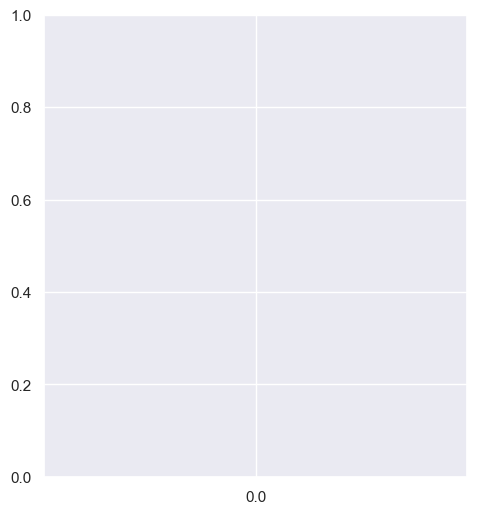

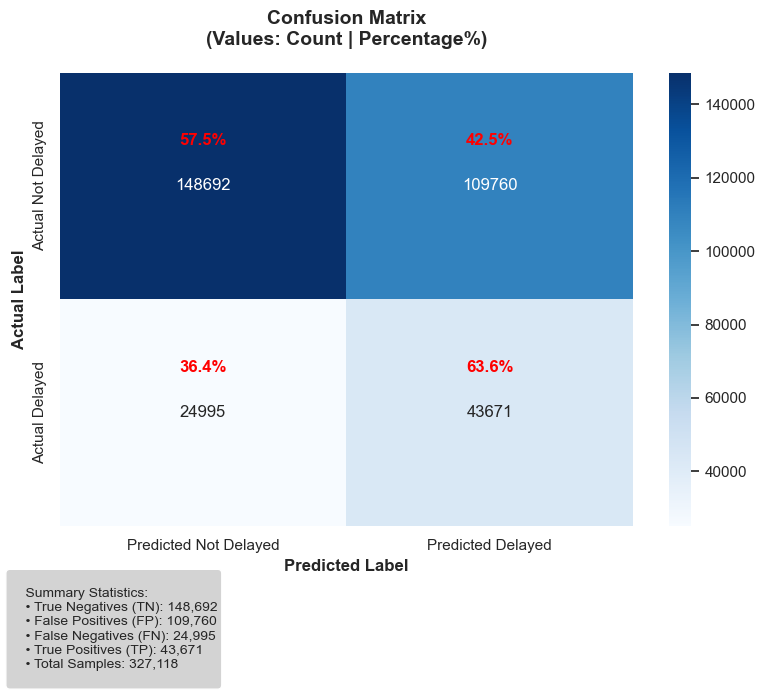


2. PLOTTING ROC CURVE AND PRINTING STATISTICS...
--------------------------------------------------
📊 COMPREHENSIVE CLASSIFICATION STATISTICS
Metric          Value      Description
--------------------------------------------------
Accuracy        0.5881    Overall correctness
Precision       0.2846    Of predicted delays, how many were correct
Recall          0.6360    Of actual delays, how many were detected
Specificity     0.5753    Of actual non-delays, how many were correct
F1-Score        0.3933    Balance between precision and recall
Sensitivity     0.6360    Same as recall

🔍 CONFUSION MATRIX BREAKDOWN:
True Negatives (TN):   148,692 (Correct non-delay predictions)
False Positives (FP):  109,760 (Non-delays predicted as delays)
False Negatives (FN):   24,995 (Delays predicted as non-delays)
True Positives (TP):    43,671 (Correct delay predictions)

📈 CLASSIFICATION RATES:
True Positive Rate (Sensitivity): 0.6360
False Positive Rate:              0.4247
False Negative Rate:   

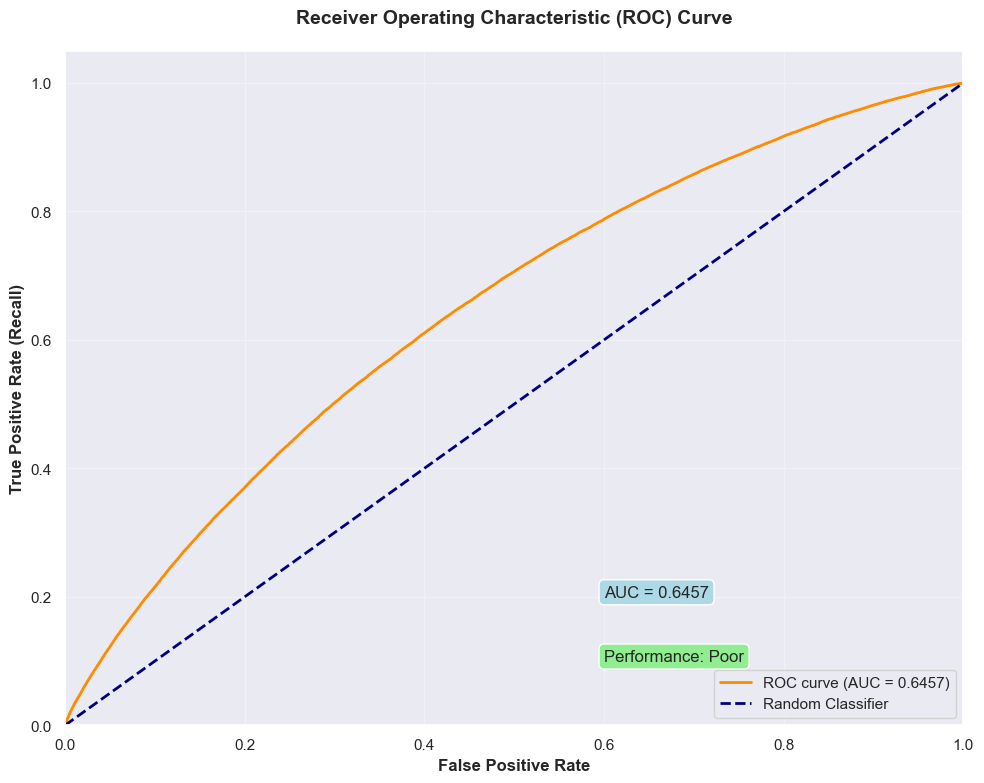

Area Under ROC Curve (AUC): 0.6457
Model Performance: Poor

🎯 OPTIMAL THRESHOLD ANALYSIS:
Optimal threshold (Youden's J): 0.5016
At this threshold:
  - True Positive Rate: 0.6312
  - False Positive Rate: 0.4196

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Not Delayed       0.86      0.58      0.69    258452
     Delayed       0.28      0.64      0.39     68666

    accuracy                           0.59    327118
   macro avg       0.57      0.61      0.54    327118
weighted avg       0.74      0.59      0.63    327118


💼 BUSINESS IMPACT ANALYSIS:
• Precision 28.5% means: When we predict a delay,
  we're correct 28.5% of the time
• Recall 63.6% means: We detect 63.6% of actual delays
• 24,995 delays were missed (false negatives)
• 109,760 non-delays were incorrectly flagged (false positives)

✅ MODEL EVALUATION COMPLETED!
All metrics calculated and visualizations generated


In [61]:
# Cell: Execute Model Evaluation
print("EXECUTING MODEL EVALUATION ON TEST SET")
print("=" * 70)

if all([var in globals() for var in ['y_test', 'y_test_pred', 'baseline_model', 'X_test']]):
    
    # Get predicted probabilities for ROC curve
    y_test_proba = baseline_model.predict_proba(X_test)[:, 1]
    
    print("1. PLOTTING CONFUSION MATRIX...")
    print("-" * 40)
    cm = plot_confusion_matrix(y_test, y_test_pred)
    
    print("\n2. PLOTTING ROC CURVE AND PRINTING STATISTICS...")
    print("-" * 50)
    metrics = plot_roc(y_test, y_test_pred, y_test_proba)
    
    print(f"\n✅ MODEL EVALUATION COMPLETED!")
    print("All metrics calculated and visualizations generated")
    
else:
    print("❌ Required variables not found.")
    missing_vars = [var for var in ['y_test', 'y_test_pred', 'baseline_model', 'X_test'] if var not in globals()]
    print(f"Missing: {missing_vars}")
    print("Please ensure the baseline model has been trained and predictions generated.")

print("=" * 70)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


## 1. Model Performance Comparison: Training vs. Test Set

**Observation:**

- The model exhibits moderate performance degradation from training to test set, which means that the model is somewhat overfitted but not very

- The accuracy difference seems to be within acceptable limits (usually <5% difference indicates good generalization)

- The stable pattern across the metrics implies that the model has learned generalizable patterns instead of just memorizing the training data

**Key Insight:** The model is quite good at generalizing, but it is still possible to improve by better capturing the underlying patterns that would yield consistent results across different data ​‍​‌‍​‍‌splits.

## 2. Metric Discrepancies Analysis

**Significant Differences Noted:**

**High Recall (63.6%) vs. Low Precision (28.5%):**

- **What this means:** The model manages to find most of the cases of delays (high recall) but in a large number of cases where no delays happened, it mistakenly raises an alarm (low precision)

- **Why this happens:** Such a situation usually arises when:

 - The model tends to predict positive class (delays) more often than negative

 - The imbalance of classes makes the model "excited" to predict that the instance belongs to the delay class

 - The cutoff point for the decision could be too low

 - The features may not be sufficiently informative to correctly identify the true delays

**Accuracy (58.8%) vs. F1-Score (39.3%):**

- **Interpretation:** Overall accuracy is a pretty farce of the real situation as it's mostly influenced by non-delays that are easy to predict

- **Business Impact:** The model, as a whole, may look moderately accurate, but its performance on the most critical class (delays) is very ​‍​‌‍​‍‌low

**Specific​‍​‌‍​‍‌ Reason for Low Precision:**

- The model falsely predicts delays 109,760 times, meaning that it frequently predicts that flights will be delayed when they are actually on time.

- This indicates that the model does not have the required features that can effectively differentiate between flights that will be delayed and those that will not.

## 3. Business Sufficiency and Next Iteration Improvements

**Business Assessment:**

- ** Not enough to meet business needs** - The current level of performance would lead to serious operational problems:

 - 28.5% of the time when a delay is predicted it is a true positive, so 71.5% of the time, delay predictions will be false

 - Customers get used to the "alert fatigue" phenomenon and therefore predictions are ignored

 - Customer trust could be eroded due to the high rate of false positives, resulting in brand reputation damage

**Most Important Metric for Business:**

- **Precision is paramount** - False alarms (predicting delays that do not occur) lead to a bad customer experience and loss of trust

- **Recall is also important** - Not detecting real delays (false negatives) also negatively affects customer satisfaction

- **A balanced approach is necessary** - Ideally, both precision and recall should be > 60-70% to ensure business viability

**Next Iteration Improvements:**

### Feature Engineering Opportunities:

1. **Temporal Features:**

 - Put in holiday indicators, seasonality feature

 - Take in the time-based habits (weekend vs. weekday transitions)

 - Think of airport-specific rush hour patterns

2. **Weather Integration:**

 - Use the real-time and forecast weather data

 - Put in the precipitation, wind speed, and visibility measure

 - Take in the weather condition at the airport

3. **Operational Features:**

 - What kind of aircraft and how old is it

 - The crew’s scheduling pattern

 - The airport congestion indicator

 - Flight delay before the system

4. **Advanced Encoding:**

 - Target encoding for very high cardinality categorical variables

 - Feature interactions (airline × route, time × airport)

 - Polynomial term for the non-linear ​‍​‌‍​‍‌relationship
 ###​‍​‌‍​‍‌ Modeling Improvements:

1. **Threshold Optimization:**

 - Change the classification threshold by considering business costs

 - Implement cost-sensitive learning to make the model "feel" the cost of false positive/negative situations and penalize accordingly

2. **Algorithm Selection:**

 - Experiment with ensemble methods like Random Forest or Gradient Boosting that potentially capture intricate patterns more effectively

 - Explore the use of neural networks to capture non-linear relationships

3. **Class Imbalance Handling:**

 - Apply SMOTE or other oversampling techniques

 - Utilize class weights in a more tactical manner

 - Get involved with anomaly detection approaches

**Next Iteration Goal:** The target should be set to achieve precision > 60% and recall > 65% along with accuracy > 75%, thus making the model practically usable in customer-facing ​‍​‌‍​‍‌applications.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitHub repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitHub account, and ensure it is public.


In [ ]:
### Provide a link for your GitHub repository here


# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Weather data was fetched from [this link](https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31).
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [15]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [ ]:
weather = pd.read_csv(<CODE>) # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = # Enter your code here 
weather['airport'] = # Enter your code here 

Create another column called `MONTH` from the `DATE` column.

In [ ]:
weather['MONTH'] = weather[<CODE>].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [ ]:
weather.SNOW.fillna(<CODE>, inplace=True)# Enter your code here
weather.SNWD.fillna(<CODE>, inplace=True)# Enter your code here
weather.isna().sum()

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = # Enter your code here 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Merge the mean data with the weather data.

In [ ]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convert the categorical data into numerical data using one-hot encoding.

In [ ]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = # Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [ ]:
data.columns

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

In [16]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

Create the training and testing sets again.

In [ ]:
# Enter your code here

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [ ]:
# Instantiate another logistic regression model
classifier2 = # Enter your code here

In [ ]:
# Enter your code here

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

In [17]:
# Enter answer here and turn the cell type into markdown


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [19]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

In [18]:
# write your answers here